In [ ]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.7 MB/s eta 0:00:00


In [ ]:
# import packages
import pandas as pd
import numpy as np
import csv
import random
from scipy import optimize
import requests
import os
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from pypfopt import HRPOpt
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "drive/MyDrive/Final/data/"

/content/drive/MyDrive/Final/data


In [ ]:
# select exchange - Binance
exchange = input('Please select the crypto exchange: ')

Please select the crypto exchange: Bitstamp


In [ ]:
# select cryptocurrency - SOLUSDT (start in 2020) - MATICUSDT (died in 09 09 24) # 'SOLUSDT' 'MATICUSDT'
"""
['BTCUSD', 'ETHUSD', 'XRPUSD', 'ADAUSD', 'DOGEUSD', 'DOTUSD', 'LTCUSD']
"""
cryptos = []
crypto = "d"
while crypto!='q':
  try:
    crypto = input('Please enter the cryptocurrency code or press q to quit: ')
    if crypto != 'q':
      cryptos.append(crypto)
  except crypto=="":
    print("Please enter the cryptocurrency code")
print(f"Your selected cryptos: {cryptos}")

Please enter the cryptocurrency code or press q to quit: BTCUSD
Please enter the cryptocurrency code or press q to quit: ETHUSD
Please enter the cryptocurrency code or press q to quit: XRPUSD
Please enter the cryptocurrency code or press q to quit: BNBUSD
Please enter the cryptocurrency code or press q to quit: ADAUSD
Please enter the cryptocurrency code or press q to quit: DOGEUSD
Please enter the cryptocurrency code or press q to quit: DOTUSD
Please enter the cryptocurrency code or press q to quit: LTCUSD
Please enter the cryptocurrency code or press q to quit: BCHUSD
Please enter the cryptocurrency code or press q to quit: q
Your selected cryptos: ['BTCUSD', 'ETHUSD', 'XRPUSD', 'BNBUSD', 'ADAUSD', 'DOGEUSD', 'DOTUSD', 'LTCUSD', 'BCHUSD']


In [ ]:
# cryptos=['BTCUSD', 'ETHUSD', 'XRPUSD', 'ADAUSD', 'DOGEUSD', 'DOTUSD', 'LTCUSD', 'SOLUSD']

In [ ]:
# select frequency
freq_ok = 0
while freq_ok == 0:
    freq_in = input('Please select frequency (daily/hourly): ')
    if freq_in == 'daily':
        freq = 'd'
        freq_ok = 1
    elif freq_in == 'hourly':
        freq = '1h'
        freq_ok = 1
    else:
        print("Incorrect input")

Please select frequency (daily/hourly): daily


# Data Collection and Analysis

In this notebook, we'll use one way to scrap some cryptocurrency data from the internet. It is not the only way you can obtain data, and probabily not the best one. But it is a good application of the things seen in class.

We are using API data from cryptodatadownload.com

After creating our database, we will take a first analysis of our time series with plots and summary statistics.

### Data collection
In the code below, we select the frequency, the exchange, and the code of the cryptocurrency that we select. The code in the data collection part must be run multiple times, one for every frequency, exchange and cryptocurrency code. We could download everything that we need in one run by creating a list of values for each of the three attributes and using loops.

## Daily Data collection and time series analysis


In [ ]:
# create paths a.k.a create relevant folders
exchange_path = os.getcwd() + '/' + exchange
if not os.path.exists(exchange_path):
    os.mkdir(exchange_path)
output_path = exchange_path + '/' + freq_in
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [ ]:
# creating empty files for each crypto
for crypto in cryptos:
    file_path = output_path + '/' + crypto + '.csv'

    try:
      with open(file_path, "w") as f:
          print(f"File created successfully at {file_path}")
    except FileExistsError:
            print(f"File already exists at {file_path}")

File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/daily/BTCUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/daily/ETHUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/daily/XRPUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/daily/ADAUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/daily/DOGEUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/daily/DOTUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/daily/LTCUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/daily/SOLUSD.csv


In [ ]:
# Checking the new assets
#pd.read_csv("/content/drive/MyDrive/Final/data/binance/daily/ADAUSDT.csv").tail()

In [ ]:
for crypto in cryptos:
    url = 'https://www.cryptodatadownload.com/cdd/' + exchange + '_' + crypto + '_' + freq + '.csv'

    # download from API with the requests module
    response = requests.get(url)

    # save data in csv file
    if response.status_code == 200:
        # Decode the content
        decoded_content = response.content.decode('utf-8')

        # Split the content into lines
        csv_lines = decoded_content.splitlines()

        # Use the csv module to write to a file
        with open(f'{output_path}/{crypto}.csv', mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            for line in csv.reader(csv_lines[1:]):
                writer.writerow(line)

        print(f"CSV file saved as {crypto}.csv")

CSV file saved as BTCUSD.csv
CSV file saved as ETHUSD.csv
CSV file saved as XRPUSD.csv
CSV file saved as ADAUSD.csv
CSV file saved as DOGEUSD.csv
CSV file saved as DOTUSD.csv
CSV file saved as LTCUSD.csv
CSV file saved as SOLUSD.csv


### Database creation
In the code below, we select the frequency and the exchange. Then we create a database with all the prices of the cryptocurrencies we downloaded with that specific frequency and exchange.

In [ ]:
# load files
path = exchange_path + '/' + freq_in + '/'
file_names = [f for f in os.listdir(path) if not f.startswith('.')]

dataframes = {}
for file_name in file_names:
    name = file_name.split('/')[-1].split('.')[0]
    dataframes[name] = pd.read_csv(path+file_name)

We now identify the common columns for all the different cryptocurrencies to create a database for each attribute that collects values for every cryptocurrency.

In [ ]:
# identifying common columns
common_columns = set.intersection(*[set(df.columns) for df in dataframes.values()])
common_columns.remove('unix')
common_columns.remove('symbol')
common_columns.remove('date')

In [ ]:
# create combined dataframes for each attribute
for column in common_columns:
    combined_df = pd.DataFrame()
    for name, df in dataframes.items():
        # Select relevant columns
        temp_df = df[['date', column]].copy()
        temp_df.rename(columns={column: name}, inplace=True)  # Rename column to the dataset's name
        combined_df = combined_df.merge(temp_df, on='date', how='outer') if not combined_df.empty else temp_df

    # Saving the combined DataFrame as a CSV file
    combined_df.to_csv(f'{exchange_path}' + f'/{freq}_{column}.csv', index=False)

In [ ]:
combined_df.dropna(inplace=True)
combined_df.head()

,date,ETHUSD,BTCUSD,DOGEUSD,XRPUSD,LTCUSD,DOTUSD,SOLUSD,ADAUSD
2945,2022-12-21 00:00:00,1214.0,16824.0,0.07330,0.34498,65.44,4.480,12.0876,0.25280
2946,2022-12-22 00:00:00,1218.0,16821.0,0.07739,0.34961,66.15,4.531,11.7364,0.25625
2947,2022-12-23 00:00:00,1220.3,16779.0,0.07691,0.35452,65.78,4.475,11.7805,0.25938
2948,2022-12-24 00:00:00,1220.5,16839.0,0.07783,0.35203,65.76,4.452,11.3959,0.25872
2949,2022-12-25 00:00:00,1218.1,16828.0,0.07631,0.34558,69.14,4.469,11.3882,0.25918


### Time series analysis
We now load only the closing prices and try to understand how each time series behaves and is distributed.

In [ ]:
# load data
path = exchange_path + '/'
file_name = path + freq + '_close.csv'
daily_data = pd.read_csv(file_name)

daily_data["date"] = pd.to_datetime(daily_data["date"])
daily_data.set_index('date', inplace=True)
daily_data.sort_values(by='date', ascending=True, inplace=True)
daily_data.drop(daily_data.tail(1).index,inplace=True)

In [ ]:
daily_data.dropna(inplace=True)

In [ ]:
daily_data = daily_data[daily_data.index >= '2022-12-22']
daily_data = daily_data[daily_data.index < '2024-12-02']
daily_data.head()

,ETHUSD,BTCUSD,DOGEUSD,XRPUSD,LTCUSD,DOTUSD,SOLUSD,ADAUSD
date,,,,,,,,
2022-12-22,1218.0,16821.0,0.07739,0.34961,66.15,4.531,11.7364,0.25625
2022-12-23,1220.3,16779.0,0.07691,0.35452,65.78,4.475,11.7805,0.25938
2022-12-24,1220.5,16839.0,0.07783,0.35203,65.76,4.452,11.3959,0.25872
2022-12-25,1218.1,16828.0,0.07631,0.34558,69.14,4.469,11.3882,0.25918
2022-12-26,1227.7,16917.0,0.07481,0.36613,70.60,4.574,11.3287,0.26332


In [ ]:
# number of assets
N_assets_tot = daily_data.shape[1]

### Plot the data
One of the best ways to understand the behaviour of data is plotting and visualizing.

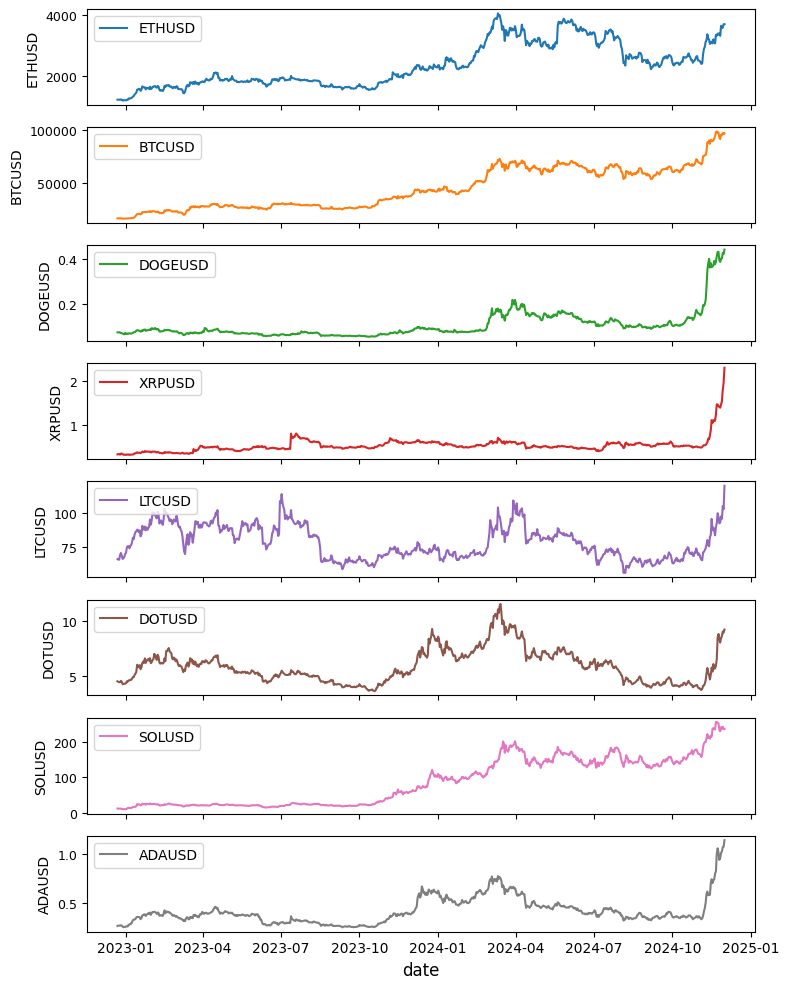

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a color palette
colors = sns.color_palette("tab10", len(daily_data.columns))

# Plot the data
fig, axes = plt.subplots(len(daily_data.columns), 1, figsize=(8, 10), sharex=True)

for i, column in enumerate(daily_data.columns):
    axes[i].plot(daily_data.index, daily_data[column], color=colors[i], label=column, linewidth=1.5)
    axes[i].legend(loc="upper left", fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)
    axes[i].tick_params(axis="y", labelsize=9)

axes[-1].set_xlabel("date", fontsize=12)
plt.tight_layout()
plt.show()

### Summary statistics
Summary statistics give us a better idea of the distribution of our data. Useful statistics are:
- **Mean**. The mean of a dataset is the sum of all values divided by the total number of values. It’s the most commonly used measure of central tendency and is often referred to as the “average.”
- **Standard deviation**. The standard deviation is the average amount of variability in your dataset. It tells you, on average, how far each value lies from the mean. A high standard deviation means that values are generally far from the mean, while a low standard deviation indicates that values are clustered close to the mean.
- **Minimum**. The minimum value of a dataset.
- **Median**. The median is the value that’s exactly in the middle of a dataset when it is ordered. It’s a measure of central tendency that separates the lowest 50% from the highest 50% of values. It is also known as the 50% percentile.
- **Maximum**.The maximum value of a dataset.
- **Variance**. The variance is a measure of variability. It is calculated by taking the average of squared deviations from the mean. Variance tells you the degree of spread in your data set. The more spread the data, the larger the variance is in relation to the mean.
- **Skewness**. Skewness is a measure of the asymmetry of a distribution. A positively skewed distribution is longer on the right side of its peak, and a negatively skewed distribution is longer on the left side of its peak.
- **Kurtosis**. Kurtosis is a measure of the tailedness of a distribution, or how often outliers occur. Distributions with low kurtosis have thin tails, while distributions with high kurtosis have fat tails.
- ...

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

stats = daily_data.describe()
stats.loc['var'] = daily_data.var().tolist()
stats.loc['skew'] = daily_data.skew().tolist()
stats.loc['kurt'] = daily_data.kurtosis().tolist()

stats

,ETHUSD,BTCUSD,DOGEUSD,XRPUSD,LTCUSD,DOTUSD,SOLUSD,ADAUSD
count,711.000000,7.110000e+02,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000
mean,2352.410408,4.485977e+04,0.107650,0.549246,78.313010,5.895940,86.330140,0.411179
std,714.646194,1.949460e+04,0.061564,0.167837,11.924132,1.519807,66.761935,0.140939
min,1189.500000,1.652800e+04,0.057750,0.337890,55.990000,3.637000,9.662400,0.241210
25%,1793.600000,2.742600e+04,0.073235,0.483080,68.410000,4.609500,21.792300,0.325245
50%,2222.800000,4.156000e+04,0.085760,0.524740,75.600000,5.667000,72.240000,0.376340
75%,2969.000000,6.315050e+04,0.123865,0.596675,88.280000,6.767500,144.907900,0.459315
max,4066.500000,9.901300e+04,0.441240,2.296720,119.660000,11.563000,256.964700,1.148960
var,510719.181948,3.800394e+08,0.003790,0.028169,142.184926,2.309812,4457.156002,0.019864
skew,0.554997,4.719608e-01,3.166677,4.866815,0.428221,0.900316,0.401444,1.763701


### Returns
When we construct portfolios, we are more interested in the differences in prices than levels, as we want to focus on how much we can make. Moreover, thinking in differences makes all the series comparable.

In [ ]:
# compute returns
daily_returns = daily_data.pct_change()[1:]

In [ ]:
# Saving the Daily Returns
daily_returns.to_csv(f"daily_assets_returns.csv")

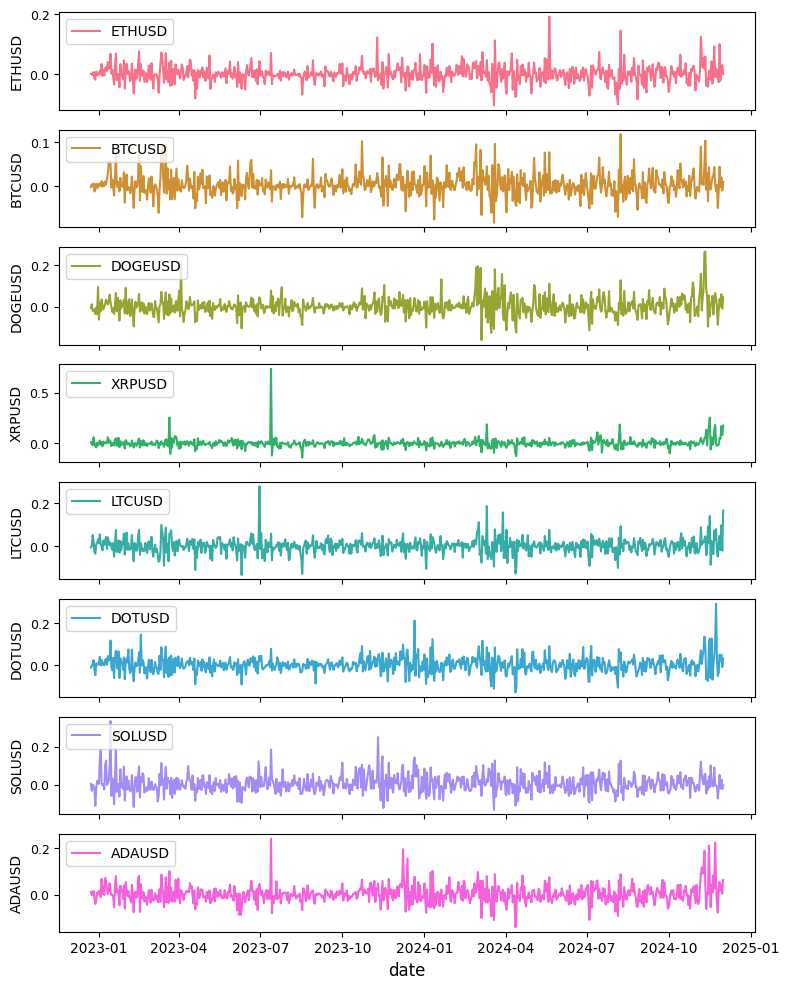

In [ ]:
# Define a color palette for returns plot
return_colors = sns.color_palette("husl", len(daily_returns.columns))

# Plot the returns
fig, axes = plt.subplots(len(daily_returns.columns), 1, figsize=(8, 10), sharex=True)

for i, column in enumerate(daily_returns.columns):
    axes[i].plot(daily_returns.index, daily_returns[column], color=return_colors[i], label=column, linewidth=1.5)
    axes[i].legend(loc="upper left", fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)
    axes[i].tick_params(axis="y", labelsize=9)

axes[-1].set_xlabel("date", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

stats_ret = daily_returns.describe()
stats_ret.loc['var'] = daily_returns.var().tolist()
stats_ret.loc['skew'] = daily_returns.skew().tolist()
stats_ret.loc['kurt'] = daily_returns.kurtosis().tolist()

stats

,ETHUSD,BTCUSD,DOGEUSD,XRPUSD,LTCUSD,DOTUSD,SOLUSD,ADAUSD
count,711.000000,7.110000e+02,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000
mean,2352.410408,4.485977e+04,0.107650,0.549246,78.313010,5.895940,86.330140,0.411179
std,714.646194,1.949460e+04,0.061564,0.167837,11.924132,1.519807,66.761935,0.140939
min,1189.500000,1.652800e+04,0.057750,0.337890,55.990000,3.637000,9.662400,0.241210
25%,1793.600000,2.742600e+04,0.073235,0.483080,68.410000,4.609500,21.792300,0.325245
50%,2222.800000,4.156000e+04,0.085760,0.524740,75.600000,5.667000,72.240000,0.376340
75%,2969.000000,6.315050e+04,0.123865,0.596675,88.280000,6.767500,144.907900,0.459315
max,4066.500000,9.901300e+04,0.441240,2.296720,119.660000,11.563000,256.964700,1.148960
var,510719.181948,3.800394e+08,0.003790,0.028169,142.184926,2.309812,4457.156002,0.019864
skew,0.554997,4.719608e-01,3.166677,4.866815,0.428221,0.900316,0.401444,1.763701


## Hourly Data Collection and Analysis

### Data collection

In [ ]:
# select frequency
freq_ok = 0
while freq_ok == 0:
    freq_in = input('Please select frequency (daily/hourly): ')
    if freq_in == 'daily':
        freq = 'd'
        freq_ok = 1
    elif freq_in == 'hourly':
        freq = '1h'
        freq_ok = 1
    else:
        print("Incorrect input")

In [ ]:
# create paths a.k.a create relevant folders
exchange_path = os.getcwd() + '/' + exchange
if not os.path.exists(exchange_path):
    os.mkdir(exchange_path)
output_path = exchange_path + '/' + freq_in
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [ ]:
# creating empty files for each crypto
for crypto in cryptos:
    file_path = output_path + '/' + crypto + '.csv'

    try:
      with open(file_path, "w") as f:
          print(f"File created successfully at {file_path}")
    except FileExistsError:
            print(f"File already exists at {file_path}")

In [ ]:
for crypto in cryptos:
    url = 'https://www.cryptodatadownload.com/cdd/' + exchange + '_' + crypto + '_' + freq + '.csv'

    # download from API with the requests module
    response = requests.get(url)

    # save data in csv file
    if response.status_code == 200:
        # Decode the content
        decoded_content = response.content.decode('utf-8')

        # Split the content into lines
        csv_lines = decoded_content.splitlines()

        # Use the csv module to write to a file
        with open(f'{output_path}/{crypto}.csv', mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            for line in csv.reader(csv_lines[1:]):
                writer.writerow(line)

        print(f"CSV file saved as {crypto}.csv")

### Database creation
In the code below, we select the frequency and the exchange. Then we create a database with all the prices of the cryptocurrencies we downloaded with that specific frequency and exchange.

In [ ]:
# load files
path = exchange_path + '/' + freq_in + '/'
file_names = [f for f in os.listdir(path) if not f.startswith('.')]

dataframes = {}
for file_name in file_names:
    name = file_name.split('/')[-1].split('.')[0]
    dataframes[name] = pd.read_csv(path+file_name)

We now identify the common columns for all the different cryptocurrencies to create a database for each attribute that collects values for every cryptocurrency.

In [ ]:
# identifying common columns
common_columns = set.intersection(*[set(df.columns) for df in dataframes.values()])
common_columns.remove('unix')
common_columns.remove('symbol')
common_columns.remove('date')

In [ ]:
# create combined dataframes for each attribute
for column in common_columns:
    combined_df = pd.DataFrame()
    for name, df in dataframes.items():
        # Select relevant columns
        temp_df = df[['date', column]].copy()
        temp_df.rename(columns={column: name}, inplace=True)  # Rename column to the dataset's name
        combined_df = combined_df.merge(temp_df, on='date', how='outer') if not combined_df.empty else temp_df

    # Saving the combined DataFrame as a CSV file
    combined_df.to_csv(f'{exchange_path}' + f'/{freq}_{column}.csv', index=False)

In [ ]:
combined_df.head()

### Time series analysis
We now load only the closing prices and try to understand how each time series behaves and is distributed.

In [ ]:
# load data
path = exchange_path + '/'
file_name = path + freq + '_close.csv'
hourly_data = pd.read_csv(file_name)

hourly_data["date"] = pd.to_datetime(hourly_data["date"])
hourly_data.set_index('date', inplace=True)
hourly_data.sort_values(by='date', ascending=True, inplace=True)
hourly_data.drop(hourly_data.tail(1).index,inplace=True)

In [ ]:
hourly_data = hourly_data[hourly_data.index >= '2022-12-22']
hourly_data = hourly_data[hourly_data.index < '2024-12-02']
print(hourly_data.shape)
hourly_data.head()

In [ ]:
# number of assets
N_assets_tot = hourly_data.shape[1]

NameError: name 'hourly_data' is not defined

#### Plot the data
One of the best ways to understand the behaviour of data is plotting and visualizing.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a color palette
colors = sns.color_palette("tab10", len(hourly_data.columns))

# Plot the data
fig, axes = plt.subplots(len(hourly_data.columns), 1, figsize=(8, 10), sharex=True)

for i, column in enumerate(hourly_data.columns):
    axes[i].plot(hourly_data.index, hourly_data[column], color=colors[i], label=column, linewidth=1.5)
    axes[i].legend(loc="upper left", fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)
    axes[i].tick_params(axis="y", labelsize=9)

axes[-1].set_xlabel("date", fontsize=12)
plt.tight_layout()
plt.show()

#### Summary statistics
Summary statistics give us a better idea of the distribution of our data. Useful statistics are:
- **Mean**. The mean of a dataset is the sum of all values divided by the total number of values. It’s the most commonly used measure of central tendency and is often referred to as the “average.”
- **Standard deviation**. The standard deviation is the average amount of variability in your dataset. It tells you, on average, how far each value lies from the mean. A high standard deviation means that values are generally far from the mean, while a low standard deviation indicates that values are clustered close to the mean.
- **Minimum**. The minimum value of a dataset.
- **Median**. The median is the value that’s exactly in the middle of a dataset when it is ordered. It’s a measure of central tendency that separates the lowest 50% from the highest 50% of values. It is also known as the 50% percentile.
- **Maximum**.The maximum value of a dataset.
- **Variance**. The variance is a measure of variability. It is calculated by taking the average of squared deviations from the mean. Variance tells you the degree of spread in your data set. The more spread the data, the larger the variance is in relation to the mean.
- **Skewness**. Skewness is a measure of the asymmetry of a distribution. A positively skewed distribution is longer on the right side of its peak, and a negatively skewed distribution is longer on the left side of its peak.
- **Kurtosis**. Kurtosis is a measure of the tailedness of a distribution, or how often outliers occur. Distributions with low kurtosis have thin tails, while distributions with high kurtosis have fat tails.
- ...

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

stats = hourly_data.describe()
stats.loc['var'] = hourly_data.var().tolist()
stats.loc['skew'] = hourly_data.skew().tolist()
stats.loc['kurt'] = hourly_data.kurtosis().tolist()

stats

#### Returns
When we construct portfolios, we are more interested in the differences in prices than levels, as we want to focus on how much we can make. Moreover, thinking in differences makes all the series comparable.

In [ ]:
# compute returns
hourly_returns = hourly_data.pct_change()[1:]

In [ ]:
# Saving the Hourly Returns
hourly_returns.to_csv(f"hourly_assets_returns.csv")

In [ ]:
# Define a color palette for returns plot
return_colors = sns.color_palette("husl", len(hourly_returns.columns))

# Plot the returns
fig, axes = plt.subplots(len(hourly_returns.columns), 1, figsize=(8, 10), sharex=True)

for i, column in enumerate(hourly_returns.columns):
    axes[i].plot(hourly_returns.index, hourly_returns[column], color=return_colors[i], label=column, linewidth=1.5)
    axes[i].legend(loc="upper left", fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)
    axes[i].tick_params(axis="y", labelsize=9)

axes[-1].set_xlabel("date", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

stats_ret = hourly_returns.describe()
stats_ret.loc['var'] = hourly_returns.var().tolist()
stats_ret.loc['skew'] = hourly_returns.skew().tolist()
stats_ret.loc['kurt'] = hourly_returns.kurtosis().tolist()

stats

# Dr. Martina's Portfolio Construction & Evaluation

## Daily Portfolio Construction and Evaluation

In this notebook, I'll show you some of the investment strategies seen in class and how to evaluate them.

### Select assets and time interval

In [ ]:
daily_returns

,ETHUSD,BTCUSD,DOGEUSD,XRPUSD,LTCUSD,DOTUSD,SOLUSD,ADAUSD
date,,,,,,,,
2022-12-23,0.001888,-0.002497,-0.006202,0.014044,-0.005593,-0.012359,0.003758,0.012215
2022-12-24,0.000164,0.003576,0.011962,-0.007024,-0.000304,-0.005140,-0.032647,-0.002545
2022-12-25,-0.001966,-0.000653,-0.019530,-0.018322,0.051399,0.003819,-0.000676,0.001778
2022-12-26,0.007881,0.005289,-0.019657,0.059465,0.021117,0.023495,-0.005225,0.015973
2022-12-27,-0.013603,-0.012827,-0.012431,0.003305,-0.026487,-0.020114,-0.025696,-0.016064
...,...,...,...,...,...,...,...,...
2024-11-27,0.100782,0.044056,0.037474,0.052574,0.048594,0.049671,0.050682,0.055141
2024-11-28,-0.021488,-0.003303,0.001420,0.048480,-0.018393,0.021767,-0.020054,0.016963
2024-11-29,0.004191,0.019350,0.060274,0.167859,0.097561,0.048744,0.025689,0.041459


In [ ]:
# asset selection
select_asset = 1
if select_asset:
    select = ["BTCUSD","ETHUSD","XRPUSD","ADAUSD","DOGEUSD","DOTUSD","LTCUSD","SOLUSD"] # "MATICUSDT","SOLUSDT","BNBUSDT", "ADAUSDT","DOGEUSDT","DOTUSDT","LTCUSDT"
    daily_returns = daily_returns[select]
    daily_data = daily_data[select]
else:
    daily_returns = daily_returns
    daily_data = daily_data

In [ ]:
# date selection
start_series_ret = daily_returns.apply(lambda series: series.first_valid_index())
end_series_ret = daily_returns.apply(lambda series: series.last_valid_index())
start_index_ret = max(start_series_ret)
end_index_ret = min(end_series_ret)
daily_returns = daily_returns.loc[start_index_ret:end_index_ret]

start_series_price = daily_data.apply(lambda series: series.first_valid_index())
end_series_price = daily_data.apply(lambda series: series.last_valid_index())
start_index_price = max(start_series_price)
end_index_price = min(end_series_price)
daily_data = daily_data.loc[start_index_price:end_index_price]

In [ ]:
# Checking for null values in prices
daily_data.isnull().any()

,0
BTCUSD,False
ETHUSD,False
XRPUSD,False
ADAUSD,False
DOGEUSD,False
DOTUSD,False
LTCUSD,False
SOLUSD,False


In [ ]:
# Checking for null values
daily_returns.isnull().any()

,0
BTCUSD,False
ETHUSD,False
XRPUSD,False
ADAUSD,False
DOGEUSD,False
DOTUSD,False
LTCUSD,False
SOLUSD,False


In [ ]:
# number of assets and observations
N_obs = daily_returns.shape[0]
N_assets = daily_returns.shape[1]

### Portfolio allocations

Portfolio style:
1. Long-short       
2. Long-only

In [ ]:
# select long-short
style = 1

Constraints for optimization:

In [ ]:
# e'w = 1
e = np.ones((N_assets, 1))
Aeq = e.T
beq = 1
eq_constraint = lambda w: np.dot(Aeq, w) - beq
cons = ({'type': 'eq', 'fun': eq_constraint})

# long-short vs long-only
if style:
    lub = (0, 1)
    bnds = ((lub, ) * N_assets)
else:
    bnds = None

# initialize starting vector
w0 = np.ones((N_assets, )) / N_assets

Create variables for portfolio allocations: vector of expected return, covariance matrix, and correlation matrix

In [ ]:
ret = np.array(daily_returns)

# Vector of expected returns
mu = np.mean(ret, axis = 0).reshape((N_assets, 1))

# Covariance matrix
Sigma = np.cov(ret.T)

# Vector of volatilities
sigmaVec = np.sqrt(np.diag(Sigma))

# Correlation matrix
corrMatrix = Sigma / np.outer(sigmaVec, sigmaVec)
corrMatrix[Sigma == 0] = 0

In [ ]:
print(sigmaVec)

[0.02557189 0.02931019 0.04572052 0.03914291 0.04462567 0.03894976
 0.03591513 0.04827528]


In [ ]:
# initialize dataframe to store all portfolio returns
pf_ret = pd.DataFrame()

#### Equally weighted (EW) portfolio

In [ ]:
w_EW = 1 / N_assets
rets_EW = w_EW * daily_returns
ret_EW = rets_EW.dropna()
pf_ret['EW'] = ret_EW.sum(axis = 1)

#### Fundamentally weighted (FW) portfolio

In [ ]:
# df = pd.read_csv(f'{os.getcwd()}/Binance/{freq}_Volume USDT.csv')
# df.columns = [col.lower() for col in df.columns]  # Convert column names to lowercase
# df.to_csv(f'{os.getcwd()}/Binance/{freq}_Volume USDT.csv', index=False)

In [ ]:
freq = 'd'

In [ ]:
# load data on volume
file_vol = path + freq + '_Volume USD.csv'
vol = pd.read_csv(file_vol)
vol["date"] = pd.to_datetime(vol["date"])
vol.set_index('date', inplace=True)
vol.sort_values(by='date', ascending=True, inplace=True)
vol.drop(vol.tail(1).index,inplace=True)

# select assets and dates
if select_asset:
    select = ["BTCUSD","ETHUSD","XRPUSD","ADAUSD","DOGEUSD","DOTUSD","LTCUSD","SOLUSD"]  # 'bnbusdt', , 'adausdt', 'dogeusdt', 'dotusdt', 'ltcusdt'
    df_vol = vol[select]
else:
    df_vol = vol

start_series_vol = df_vol.apply(lambda series: series.first_valid_index())
end_series_vol = df_vol.apply(lambda series: series.last_valid_index())
start_index_vol = max(start_series_vol)
end_index_vol = min(end_series_vol)
df_vol = df_vol.loc[start_index_vol:end_index_vol]

# portfolio allocation
w_FW = np.array(df_vol.mean() / df_vol.mean().sum())
rets_FW = w_FW * daily_returns
ret_FW = rets_FW.dropna()
pf_ret['FW'] = ret_FW.sum(axis = 1)

#### Minimum variance (MV) portfolio

In [ ]:
# optimization
fun_MV = lambda w: np.dot(np.dot(w.T, Sigma), w)
res_MV = optimize.minimize(fun_MV, w0, method='SLSQP', tol=1e-8, bounds=bnds, constraints=cons)

# portfolio allocation
w_MV = res_MV.x
rets_MV = w_MV * daily_returns
ret_MV = rets_MV.dropna()
pf_ret['MV'] = ret_MV.sum(axis = 1)

#### Mean-variance portfolio

In [ ]:
# risk aversion parameter
gamma = 2

# optimization
fun_meanvar = lambda w: 0.5 * gamma * np.dot(np.dot(w.T, Sigma), w) - np.dot(w.T, mu)
res_meanvar = optimize.minimize(fun_meanvar, w0, method='SLSQP', tol=1e-8, bounds=bnds, constraints=cons)

# portfolio allocation
w_meanvar = res_meanvar.x
rets_meanvar = w_meanvar * daily_returns
ret_meanvar = rets_meanvar.dropna()
pf_ret['meanvar'] = ret_meanvar.sum(axis = 1)


ret_EW.sum(axis = 1)
ret_FW.sum(axis = 1)
ret_MV.sum(axis = 1)
ret_meanvar.sum(axis = 1)

,0
date,
2022-12-23,0.005900
2022-12-24,-0.027310
2022-12-25,-0.004351
2022-12-26,0.008250
2022-12-27,-0.019655
...,...
2024-11-27,0.051076
2024-11-28,-0.005779
2024-11-29,0.055302


#### Maximum diversification (MD) portfolio

In [ ]:
# optimization
fun_MD = lambda w: np.dot(-1*w.T, sigmaVec) / (np.dot(np.dot(w.T, Sigma), w) ** 0.5)
res_MD = optimize.minimize(fun_MD, w0, method='SLSQP', tol=1e-8, bounds=bnds, constraints=cons)

# portfolio allocation
w_MD = res_MD.x
rets_MD = w_MD * daily_returns
ret_MD = rets_MD.dropna()
pf_ret['MD'] = ret_MD.sum(axis = 1)

#### Risk parity (RP) portfolio

In [ ]:
# define function to minimize
def RP_func(w, Sigma):
    x = 0
    R = np.dot(Sigma, w)
    for i in range(len(w)):
        for j in range(len(w)):
            x = x + (w[i]*R[i] - w[j]*R[j])**2
    return x

# optimization
fun_RP = lambda w: RP_func(w, Sigma)
res_RP = optimize.minimize(fun_RP, w0, method='SLSQP', tol=1e-15, bounds=bnds, constraints=cons)

# portfolio allocation
w_RP = res_RP.x
rets_RP = w_RP * daily_returns
ret_RP = rets_RP.dropna()
pf_ret['RP'] = ret_RP.sum(axis = 1)

#### Factor investing: momentum

We create a signal based on the time-series of each asset.

In [ ]:
window = 120                  # length of momentum window in days
reversalLag = -30             # Lenght of reversal window to skip in days

# initialize
mom = np.zeros((N_obs, N_assets))
w_mom = np.ones((N_obs, N_assets)) * np.nan

# compute momentum and signal
for i in range(window, N_obs+1):
    mom[i-1, :] = np.sum(ret[i-window:i+reversalLag, :], axis=0).reshape((1,N_assets))
    #w_mom[i-1, :] = (mom[i-1, :] - np.mean(mom[i-1, :])) / np.std(mom[i-1, :], ddof=1)
    w_mom[i-1, :] = mom[i-1, :] / np.sum(mom[i-1, :])

ret_mom = w_mom * daily_returns
ret_mom = ret_mom.dropna()
pf_ret['mom'] = ret_mom.sum(axis = 1)

### Portfolio evaluation

#### Plot cumulative returns

In [ ]:
pf_ret.head()

,EW,FW,MV,meanvar,MD,RP,mom
date,,,,,,,
2022-12-23,0.000657,-0.000233,-0.000331,0.005900,0.001543,0.000426,NaN
2022-12-24,-0.003995,0.001426,0.001816,-0.027310,-0.006002,-0.003081,NaN
2022-12-25,0.001981,-0.002221,-0.000245,-0.004351,0.001506,0.002774,NaN
2022-12-26,0.013542,0.010650,0.010767,0.008250,0.017369,0.013797,NaN
2022-12-27,-0.015490,-0.011740,-0.012285,-0.019655,-0.014047,-0.015264,NaN


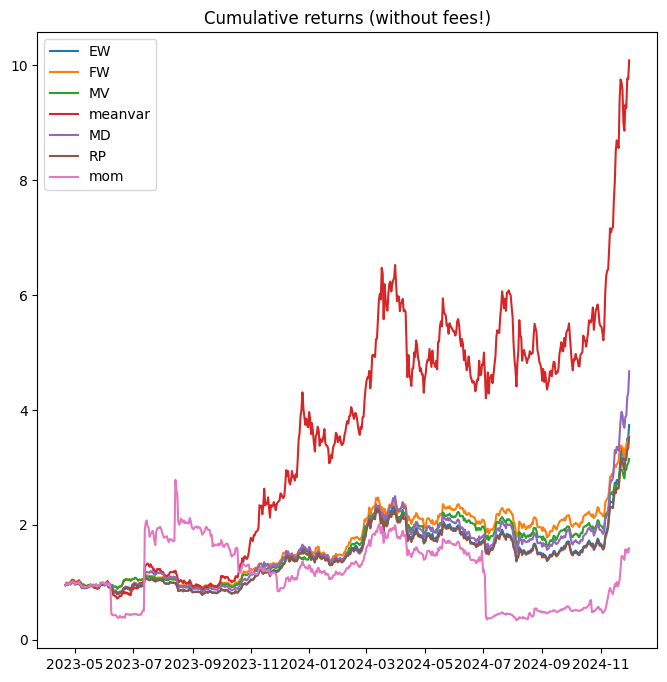

In [ ]:
pf_ret = pf_ret.dropna()


plt.figure(figsize=(8, 8))
plt.plot((1+pf_ret['EW']).cumprod(), label='EW')
plt.plot((1+pf_ret['FW']).cumprod(), label='FW')
plt.plot((1+pf_ret['MV']).cumprod(), label='MV')
plt.plot((1+pf_ret['meanvar']).cumprod(), label='meanvar')
plt.plot((1+pf_ret['MD']).cumprod(), label='MD')
plt.plot((1+pf_ret['RP']).cumprod(), label='RP')
plt.plot((1+pf_ret['mom']).cumprod(), label='mom')
plt.legend()
plt.title('Cumulative returns (without fees!)')
plt.show()

Annualized return and volatility, Sharpe ratio, maximum drawdown

In [ ]:
# annualized return and volatility
freq = 'daily'
if freq == 'monthly':
    ann_mean = ((1+pf_ret.mean()) ** 12) - 1
    ann_vol = pf_ret.std() * (12**0.5)
elif freq == 'daily':
    ann_mean = ((1+pf_ret.mean()) ** 365) - 1
    ann_vol = pf_ret.std() * (365**0.5)

# Sharpe ratio
sharpe_ratio = ann_mean / ann_vol

# maximum drawdown
cummulative_return = (1 + pf_ret).cumprod()
previous_peaks = cummulative_return.cummax()
drawdown = (previous_peaks - cummulative_return)/previous_peaks
max_drawdown = abs(drawdown.max())

Summary table for comparison

In [ ]:
summ_tab_martina = pd.DataFrame(columns=['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP'])
summ_tab_martina.loc['Annualized return'] = ann_mean
summ_tab_martina.loc['Annualized volatility'] = ann_vol
summ_tab_martina.loc['Sharpe ratio'] = sharpe_ratio
summ_tab_martina.loc['Max DD'] = max_drawdown

summ_tab_martina

,EW,FW,MV,meanvar,MD,RP
Annualized return,1.664370,1.452132,1.273342,4.607540,2.128255,1.545557
Annualized volatility,0.578896,0.480513,0.476902,0.781442,0.619798,0.561237
Sharpe ratio,2.875077,3.022046,2.670030,5.896203,3.433790,2.753840
Max DD,0.411407,0.281095,0.301437,0.355389,0.391324,0.404256


In [ ]:
pf_ret.to_csv("professor_daily_portfolio_returns.csv")

In [ ]:
professor_daily_returns = pf_ret.copy()
professor_daily_returns

,EW,FW,MV,meanvar,MD,RP,mom
date,,,,,,,
2023-04-21,-0.049235,-0.039030,-0.040305,-0.043492,-0.053474,-0.048525,-0.044698
2023-04-22,0.027896,0.023074,0.021475,0.038164,0.032676,0.026817,0.027227
2023-04-23,-0.011536,-0.008770,-0.007977,-0.020940,-0.013028,-0.010794,-0.012000
2023-04-24,-0.002361,-0.004393,-0.004380,-0.003682,0.000197,-0.002291,-0.002802
2023-04-25,0.020128,0.025501,0.024462,0.022719,0.019795,0.020585,0.022103
...,...,...,...,...,...,...,...
2024-11-27,0.054872,0.052319,0.057736,0.051076,0.051415,0.055940,0.132921
2024-11-28,0.003174,-0.000980,-0.003955,-0.005779,0.005490,0.002045,-0.038627
2024-11-29,0.058141,0.032740,0.030731,0.055302,0.084658,0.055955,0.043458


In [ ]:
professor_daily_returns.isnull().any()

,0
EW,False
FW,False
MV,False
meanvar,False
MD,False
RP,False
mom,False


## Hourly Portfolio Construction and Evaluation

In this notebook, I'll show you some of the investment strategies seen in class and how to evaluate them.

#### Select assets and time interval

In [ ]:
# Define a color palette for returns plot
return_colors = sns.color_palette("husl", len(hourly_data.columns))

# Plot the returns
fig, axes = plt.subplots(len(hourly_data.columns), 1, figsize=(8, 10), sharex=True)

for i, column in enumerate(hourly_data.columns):
    axes[i].plot(hourly_data.index, hourly_data[column], color=return_colors[i], label=column, linewidth=1.5)
    axes[i].legend(loc="upper left", fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)
    axes[i].tick_params(axis="y", labelsize=9)

axes[-1].set_xlabel("date", fontsize=12)
plt.tight_layout()
plt.show()

NameError: name 'hourly_data' is not defined

In [ ]:
# Define a color palette for returns plot
return_colors = sns.color_palette("husl", len(hourly_returns.columns))

# Plot the returns
fig, axes = plt.subplots(len(hourly_returns.columns), 1, figsize=(8, 10), sharex=True)

for i, column in enumerate(hourly_returns.columns):
    axes[i].plot(hourly_returns.index, hourly_returns[column], color=return_colors[i], label=column, linewidth=1.5)
    axes[i].legend(loc="upper left", fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)
    axes[i].tick_params(axis="y", labelsize=9)

axes[-1].set_xlabel("date", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# number of assets and observations
N_obs = hourly_returns.shape[0]
N_assets = hourly_returns.shape[1]

#### Portfolio allocations

Portfolio style:
1. Long-short       
2. Long-only

In [ ]:
# select long-short
style = 1

Constraints for optimization:

In [ ]:
# e'w = 1
e = np.ones((N_assets, 1))
Aeq = e.T
beq = 1
eq_constraint = lambda w: np.dot(Aeq, w) - beq
cons = ({'type': 'eq', 'fun': eq_constraint})

# long-short vs long-only
if style:
    lub = (0, 1)
    bnds = ((lub, ) * N_assets)
else:
    bnds = None

# initialize starting vector
w0 = np.ones((N_assets, )) / N_assets

Create variables for portfolio allocations: vector of expected return, covariance matrix, and correlation matrix

In [ ]:
ret = np.array(hourly_returns)

# Vector of expected returns
mu = np.mean(ret, axis = 0).reshape((N_assets, 1))

# Covariance matrix
Sigma = np.cov(ret.T)

# Vector of volatilities
sigmaVec = np.sqrt(np.diag(Sigma))

# Correlation matrix
corrMatrix = Sigma / np.outer(sigmaVec, sigmaVec)
corrMatrix[Sigma == 0] = 0

In [ ]:
print(sigmaVec)

In [ ]:
# initialize dataframe to store all portfolio returns
pf_ret = pd.DataFrame()

#### Equally weighted (EW) portfolio

In [ ]:
w_EW = 1 / N_assets
ret_EW = w_EW * hourly_returns
ret_EW = ret_EW.dropna()
pf_ret['EW'] = ret_EW.sum(axis = 1)

#### Fundamentally weighted (FW) portfolio

In [ ]:
freq='1h'

In [ ]:
# load data on volume
file_vol = path + freq + '_Volume USD.csv'
vol = pd.read_csv(file_vol)
vol["date"] = pd.to_datetime(vol["date"])
vol.set_index('date', inplace=True)
vol.sort_values(by='date', ascending=True, inplace=True)
vol.drop(vol.tail(1).index,inplace=True)

# select assets and dates
if select_asset:
    select = ["BTCUSD","ETHUSD","XRPUSD"]
    df_vol = vol[select]
else:
    df_vol = vol

start_series_vol = df_vol.apply(lambda series: series.first_valid_index())
end_series_vol = df_vol.apply(lambda series: series.last_valid_index())
start_index_vol = max(start_series_vol)
end_index_vol = min(end_series_vol)
df_vol = df_vol.loc[start_index_vol:end_index_vol]

# portfolio allocation
w_FW = np.array(df_vol.mean() / df_vol.mean().sum())
ret_FW = w_FW * hourly_returns
ret_FW = ret_FW.dropna()
pf_ret['FW'] = ret_FW.sum(axis = 1)

#### Minimum variance (MV) portfolio

In [ ]:
# optimization
fun_MV = lambda w: np.dot(np.dot(w.T, Sigma), w)
res_MV = optimize.minimize(fun_MV, w0, method='SLSQP', tol=1e-8, bounds=bnds, constraints=cons)

# portfolio allocation
w_MV = res_MV.x
ret_MV = w_MV * hourly_returns
ret_MV = ret_MV.dropna()
pf_ret['MV'] = ret_MV.sum(axis = 1)

#### Mean-variance portfolio

In [ ]:
# risk aversion parameter
gamma = 2

# optimization
fun_meanvar = lambda w: 0.5 * gamma * np.dot(np.dot(w.T, Sigma), w) - np.dot(w.T, mu)
res_meanvar = optimize.minimize(fun_meanvar, w0, method='SLSQP', tol=1e-8, bounds=bnds, constraints=cons)

# portfolio allocation
w_meanvar = res_meanvar.x
ret_meanvar = w_meanvar * hourly_returns
ret_meanvar = ret_meanvar.dropna()
pf_ret['meanvar'] = ret_meanvar.sum(axis = 1)

#### Maximum diversification (MD) portfolio

In [ ]:
# optimization
fun_MD = lambda w: np.dot(-1*w.T, sigmaVec) / (np.dot(np.dot(w.T, Sigma), w) ** 0.5)
res_MD = optimize.minimize(fun_MD, w0, method='SLSQP', tol=1e-8, bounds=bnds, constraints=cons)

# portfolio allocation
w_MD = res_MD.x
ret_MD = w_MD * hourly_returns
ret_MD = ret_MD.dropna()
pf_ret['MD'] = ret_MD.sum(axis = 1)

#### Risk parity (RP) portfolio

In [ ]:
# define function to minimize
def RP_func(w, Sigma):
    x = 0
    R = np.dot(Sigma, w)
    for i in range(len(w)):
        for j in range(len(w)):
            x = x + (w[i]*R[i] - w[j]*R[j])**2
    return x

# optimization
fun_RP = lambda w: RP_func(w, Sigma)
res_RP = optimize.minimize(fun_RP, w0, method='SLSQP', tol=1e-15, bounds=bnds, constraints=cons)

# portfolio allocation
w_RP = res_RP.x
ret_RP = w_RP * hourly_returns
ret_RP = ret_RP.dropna()
pf_ret['RP'] = ret_RP.sum(axis = 1)

In [ ]:
pf_ret.head()

#### Factor investing: momentum

We create a signal based on the time-series of each asset.

In [ ]:
# window = 120                  # length of momentum window in days
# reversalLag = -30             # Lenght of reversal window to skip in days

# # initialize
# mom = np.zeros((N_obs, N_assets))
# w_mom = np.ones((N_obs, N_assets)) * np.nan

# # compute momentum and signal
# for i in range(window, N_obs+1):
#     mom[i-1, :] = np.sum(ret[i-window:i+reversalLag, :], axis=0).reshape((1,N_assets))
#     #w_mom[i-1, :] = (mom[i-1, :] - np.mean(mom[i-1, :])) / np.std(mom[i-1, :], ddof=1)
#     w_mom[i-1, :] = mom[i-1, :] / np.sum(mom[i-1, :])

# ret_mom = w_mom * hourly_returns
# ret_mom = ret_mom.dropna()
# pf_ret['mom'] = ret_mom.sum(axis = 1)

In [ ]:
# import numpy as np
# import pandas as pd

# # Assuming 'hourly_returns' is your DataFrame of hourly returns with N_obs and N_assets

# # Set new momentum window for hourly data (adjust for your needs)
# window = 120 * 24  # 120 days * 6 hours/day = 720 hours for the momentum window
# reversalLag = -30 * 24  # 30 days * 6 hours/day = 180 hours for the reversal window

# # Initialize arrays
# N_obs = len(hourly_returns)  # Number of hourly observations
# N_assets = hourly_returns.shape[1]  # Number of assets
# mom = np.zeros((N_obs, N_assets))  # To store momentum signals
# w_mom = np.ones((N_obs, N_assets)) * np.nan  # To store normalized momentum weights

# # Compute momentum and signal
# for i in range(window, N_obs + 1):
#     # Momentum calculation: sum of returns over the momentum window and reversal lag
#     mom[i-1, :] = np.sum(hourly_returns[i - window:i + reversalLag, :], axis=0).reshape((1, N_assets))

#     # Normalize momentum (optional)
#     # w_mom[i-1, :] = (mom[i-1, :] - np.mean(mom[i-1, :])) / np.std(mom[i-1, :], ddof=1)

#     # Weights based on momentum (sum of momentum)
#     w_mom[i-1, :] = mom[i-1, :] / np.sum(mom[i-1, :])

# # Calculate portfolio returns using momentum weights
# ret_mom = w_mom * hourly_returns.values  # Element-wise multiplication with hourly returns
# ret_mom = pd.DataFrame(ret_mom).dropna()  # Drop any NaN values

# # Calculate total momentum strategy returns
# pf_ret = pd.DataFrame()
# pf_ret['mom'] = ret_mom.sum(axis=1)  # Sum across assets for portfolio return

# # Display results
# print("Momentum Strategy Portfolio Returns (Hourly):")
# print(pf_ret['mom'])


### Portfolio evaluation

Annualized return and volatility, Sharpe ratio, maximum drawdown

In [ ]:
# annualized return and volatility
freq = 'hourly'
if freq == 'daily':
    ann_mean = ((1+pf_ret.mean()) ** 365) - 1
    ann_vol = pf_ret.std() * (365**0.5)
elif freq == 'hourly':
    ann_mean = ((1+pf_ret.mean()) ** (365*24)) - 1
    ann_vol = pf_ret.std() * ((365*24)**0.5)

# Sharpe ratio
sharpe_ratio = ann_mean / ann_vol

# maximum drawdown
cummulative_return = (1 + pf_ret).cumprod()
previous_peaks = cummulative_return.cummax()
drawdown = (previous_peaks - cummulative_return)/previous_peaks
max_drawdown = abs(drawdown.max())

Summary table for comparison

In [ ]:
summ_tab = pd.DataFrame(columns=['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP']) # 'mom'
summ_tab.loc['Annualized return'] = ann_mean
summ_tab.loc['Annualized volatility'] = ann_vol
summ_tab.loc['Sharpe ratio'] = sharpe_ratio
summ_tab.loc['Max DD'] = max_drawdown

summ_tab

In [ ]:
pf_ret.dropna(inplace=True)

In [ ]:
pf_ret.head()

In [ ]:
pf_ret.to_csv("professor_hourly_portfolio_returns.csv")

In [ ]:
professor_hourly_portfolio_returns = pf_ret.copy()

In [ ]:
professor_hourly_portfolio_returns.isnull().any()

In [ ]:
pf_ret = pf_ret.dropna()


plt.figure(figsize=(8, 8))
plt.plot((1+pf_ret['EW']).cumprod(), label='EW')
plt.plot((1+pf_ret['FW']).cumprod(), label='FW')
plt.plot((1+pf_ret['MV']).cumprod(), label='MV')
plt.plot((1+pf_ret['meanvar']).cumprod(), label='meanvar')
plt.plot((1+pf_ret['MD']).cumprod(), label='MD')
plt.plot((1+pf_ret['RP']).cumprod(), label='RP')
#plt.plot((1+pf_ret['mom']).cumprod(), label='mom')
plt.legend()
plt.title('Cumulative returns (without fees!)')
plt.show()

# Portfolio construction and evaluation

In this notebook, I'll show you some of the investment strategies seen in class and how to evaluate them.

### Select assets and time interval

In [ ]:
# Group the data by month and calculate the standard deviation for each group
hrdaily_returns_std = professor_hourly_portfolio_returns.groupby(pd.Grouper(freq='D')).std() * np.sqrt(24)

In [ ]:
hrdaily_returns_std

NameError: name 'hrdaily_returns_std' is not defined

In [ ]:
hrdaily_returns_std.isnull().any()

### Professor's Strategies Daily Std

### Professor's Strategies Daily Returns

In [ ]:
print(professor_daily_returns.shape)
professor_daily_returns.head()

In [ ]:
professor_daily_returns.isnull().any()

In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
passive_strategy_std = dict(professor_daily_returns.std())

In [ ]:
passive_strategy_std

In [ ]:
np.random.seed(0)
random_target = float(np.random.rand(1))
random_target

In [ ]:
WTplus1_prof = random_target / hrdaily_returns_std
WTplus1_prof.index = WTplus1_prof.index + pd.Timedelta(days=1)
WTplus1_prof = WTplus1_prof[:-1]
print(WTplus1_prof.shape)
WTplus1_prof

In [ ]:
print(professor_daily_returns.shape)
WTplus1_prof.shape

In [ ]:
estimated_return = WTplus1_prof * professor_daily_returns
estimated_return = estimated_return[1:]
estimated_return

In [ ]:
estimated_return_std = dict(estimated_return.std())
estimated_return_std

In [ ]:
strategies = estimated_return_std.keys()
strategies

In [ ]:
from scipy.optimize import minimize

#targets = np.linspace(0,1,100)
#for target in targets:
my_targets={}
for strategy in strategies:

  # Example input data
  passive_strategy_ = passive_strategy_std[strategy]
  estimated_return_ = estimated_return_std[strategy]
  professor_daily_return_ = professor_daily_returns[strategy]

  # Define the function to minimize
  def objective_function(target):
      return abs(passive_strategy_ - estimated_return_)

  # Initial guess for the 'target'
  initial_guess = random.random()

  # Solve for the target using scipy.optimize
  result = minimize(objective_function, initial_guess, method='Nelder-Mead')

  # Get the optimized target
  optimized_target = result.x[0]

  # Output the result
  my_targets[strategy]=optimized_target
  #print(f"Optimized Target: {optimized_target}")
  # print(f"Passive Strategy Std: {passive_strategy_}")
  # print(f"Estimated Return Std with Optimized Target: {(optimized_target / estimated_return_) * daily_returns}")

my_targets

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Dictionary to store optimized targets
my_targets = {}
estimated_std = estimated_return_std
# Loop through each strategy
for strategy in strategies:
    # Extract relevant precomputed values
    passive_std  = passive_strategy_std[strategy]
    precomputed_std  = estimated_std[strategy]

    # Define the objective function
    def objective_function(target):
        # Adjust the precomputed standard deviation by scaling the target
        adjusted_std = precomputed_std  * target
        return abs(passive_strategy_ - adjusted_std)

    # Precomputed initial guess
    initial_guess = 1.0  # Adjust this if initial_guess_target is precomputed

    # Solve for the optimized target
    result = minimize(objective_function, initial_guess, method='Nelder-Mead')
    optimized_target = result.x[0]

    # Store the result in the targets dictionary
    my_targets[strategy] = optimized_target

# Output the optimized targets
print("Optimized Targets for Strategies:")
print(my_targets)

# Verify the optimization result
for strategy, target in my_targets.items():
    print(f"\nStrategy: {strategy}")
    print(f"Passive Strategy Std: {passive_strategy_std[strategy]}")
    print(f"Precomputed Estimated Std: {estimated_std[strategy]}")
    print(f"Optimized Adjusted Std: {estimated_std[strategy] * target}")
    print(f"Difference: {abs(passive_strategy_std[strategy] - estimated_std[strategy] * target)}")


In [ ]:
strategies = list(strategies)

In [ ]:
strategies

In [ ]:
WTplus1_ours = {}

In [ ]:
for i in strategies:
 WTplus1_ours[i]= my_targets[i] / hrdaily_returns_std[i]

In [ ]:
WTplus1_ours

In [ ]:
WTplus1_ours=pd.DataFrame(WTplus1_ours)
WTplus1_ours.index = WTplus1_ours.index + pd.Timedelta(days=1)
WTplus1_ours = WTplus1_ours[:-1]
WTplus1_ours

In [ ]:
professor_daily_returns.shape

In [ ]:
our_returns = WTplus1_ours * professor_daily_returns
our_returns = our_returns[1:]
our_returns

In [ ]:
# annualized return and volatility
freq = 'daily'
if freq == 'monthly':
    ann_mean = ((1+pf_ret.mean()) ** 12) - 1
    ann_vol = pf_ret.std() * (12**0.5)
elif freq == 'daily':
    ann_mean = ((1+pf_ret.mean()) ** 365) - 1
    ann_vol = pf_ret.std() * (365**0.5)

# Sharpe ratio
sharpe_ratio = ann_mean / ann_vol

# maximum drawdown
cummulative_return = (1 + pf_ret).cumprod()
previous_peaks = cummulative_return.cummax()
drawdown = (previous_peaks - cummulative_return)/previous_peaks
max_drawdown = abs(drawdown.max())

summ_tab_martina = pd.DataFrame(columns=['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP', 'strategy'])
summ_tab_martina.loc['Annualized return'] = ann_mean
summ_tab_martina.loc['Annualized volatility'] = ann_vol
summ_tab_martina.loc['Sharpe ratio'] = sharpe_ratio
summ_tab_martina.loc['Max DD'] = max_drawdown

summ_tab_martina

In [ ]:
# annualized return and volatility
freq = 'daily'
if freq == 'monthly':
    ann_mean = ((1+our_returns.mean()) ** 12) - 1
    ann_vol = our_returns.std() * (12**0.5)
elif freq == 'daily':
    ann_mean = ((1+our_returns.mean()) ** 365) - 1
    ann_vol = our_returns.std() * (365**0.5)

# Sharpe ratio
sharpe_ratio = ann_mean / ann_vol

# maximum drawdown
cummulative_return = (1 + our_returns).cumprod()
previous_peaks = cummulative_return.cummax()
drawdown = (previous_peaks - cummulative_return)/previous_peaks
max_drawdown = abs(drawdown.max())

summ_tab_strategy = pd.DataFrame(columns=['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP'])
summ_tab_strategy.loc['Annualized return'] = ann_mean
summ_tab_strategy.loc['Annualized volatility'] = ann_vol
summ_tab_strategy.loc['Sharpe ratio'] = sharpe_ratio
summ_tab_strategy.loc['Max DD'] = max_drawdown

summ_tab_strategy

In [ ]:
our_returns.to_csv("our_strategy_returns.csv")

In [ ]:
our_return_mu = dict(our_returns.mean())
our_return_mu

In [ ]:
professor_mu = dict(professor_daily_returns.mean())
professor_mu

In [ ]:
final_ans = {}

In [ ]:
for i in professor_mu.keys():
  final_ans[i]=our_return_mu[i]-professor_mu[i]
final_ans

In [ ]:
pf_ret = our_returns.dropna()


plt.figure(figsize=(12, 12))
plt.plot((1+pf_ret['EW']).cumprod(), label='EW')
plt.plot((1+pf_ret['FW']).cumprod(), label='FW')
plt.plot((1+pf_ret['MV']).cumprod(), label='MV')
plt.plot((1+pf_ret['meanvar']).cumprod(), label='meanvar')
plt.plot((1+pf_ret['MD']).cumprod(), label='MD')
plt.plot((1+pf_ret['RP']).cumprod(), label='RP')
#plt.plot((1+pf_ret['mom']).cumprod(), label='mom')
plt.legend()
plt.title('Cumulative returns (without fees!)')
plt.show()

In [ ]:
my_X = professor_daily_returns[1:].copy()
my_X

In [ ]:
strategies

In [ ]:
professor_daily_returns.head()

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# # Example dataset
# # Create a sample dataset
# #X = np.random.rand(100, 1) * 10  # 100 samples, single feature
# #y = 2.5 * X + np.random.randn(100, 1) * 2  # y = 2.5X + noise

# pingpong_res = {}
# for i in strategies:
#   X = my_X[i]
#   y = pf_ret[i]
#   # Split the dataset into training and testing sets
#   X_train, X_test, y_train, y_test = X[X.index < '2020-11-03'].values.reshape(-1, 1), X[X.index >= '2020-11-03'].values.reshape(-1, 1), y[y.index < '2020-11-03'].values.reshape(-1, 1), y[y.index >= '2020-11-03'].values.reshape(-1, 1) #train_test_split(X, y, test_size=0.2, random_state=42)


#   # Initialize the Linear Regression model
#   model = LinearRegression()

#   # Fit the model to the training data
#   model.fit(X_train, y_train)

#   # Predict on the test data
#   y_pred = model.predict(X_test)

#   # Evaluate the model
#   mse = mean_squared_error(y_test, y_pred)
#   r2 = r2_score(y_test, y_pred)

#   # Add a constant to X for the intercept term (needed for statsmodels)
#   X_train_sm = sm.add_constant(X_train)

#   # Fit a linear regression model with statsmodels
#   ols_model = sm.OLS(y_train, X_train_sm).fit()

#   # Display the summary (includes p-values)
#   # print(ols_model.pvalues)

#   # print("Mean Squared Error:", mse)
#   # print("R-squared:", r2)

#   # # Model coefficients
#   # print("Coefficient:", model.coef_)
#   # print("Intercept:", model.intercept_)

#   pingpong_res[i] = {"Mean Squared Error": mse,
#                      "R-squared": r2,
#                      "Coefficient": model.coef_,
#                      "Intercept": model.intercept_,
#                      "p-values":ols_model.pvalues[0]}
#   print("p-values",ols_model.pvalues[0])
# # Split the data
# #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # # Fit a linear regression model with scikit-learn
# # model = LinearRegression()
# # model.fit(X_train, y_train)

# # # Add a constant to X for the intercept term (needed for statsmodels)
# # X_train_sm = sm.add_constant(X_train)

# # # Fit a linear regression model with statsmodels
# # ols_model = sm.OLS(y_train, X_train_sm).fit()

# # # Display the summary (includes p-values)
# # print(ols_model.summary())
# pingpong_res
# pd.DataFrame(pingpong_res)

# Hierarchical Risk Parity (HRP)

The HRP method works by finding subclusters of similar assets based on returns and constructing a hierarchy from these clusters to generate weights for each asset.

Here, we will use the max Sharpe statistic. The Sharpe ratio is the ratio between returns and risk. The lower the risk and the higher the returns, the higher the Sharpe ratio. The algorithm looks for the maximum Sharpe ratio, which translates to the portfolio with the highest return and lowest risk. Ultimately, the higher the Sharpe ratio, the better the performance of the portfolio.

In [ ]:
from pypfopt import expected_returns

rets = expected_returns.returns_from_prices(daily_data)
rets.tail()

,BTCUSD,ETHUSD,XRPUSD,ADAUSD,DOGEUSD,DOTUSD,LTCUSD,SOLUSD
date,,,,,,,,
2024-11-27,0.044056,0.100782,0.052574,0.055141,0.037474,0.049671,0.048594,0.050682
2024-11-28,-0.003303,-0.021488,0.048480,0.016963,0.001420,0.021767,-0.018393,-0.020054
2024-11-29,0.019350,0.004191,0.167859,0.041459,0.060274,0.048744,0.097561,0.025689
2024-11-30,-0.010983,0.031160,0.084063,0.004697,-0.009549,-0.010157,-0.021459,-0.024250
2024-12-01,0.008814,0.001025,0.175641,0.063655,0.045196,0.030225,0.166277,-0.003266


In [ ]:
mu = mean_historical_return(daily_data)
S = CovarianceShrinkage(daily_data).ledoit_wolf()

In [ ]:
# ef = EfficientFrontier(mu, S) # Long-only
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1)) #long-short
weights = ef.min_volatility()

cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))

{'BTCUSD': 0.80566, 'ETHUSD': 0.20885, 'XRPUSD': 0.09521, 'ADAUSD': -0.05602, 'DOGEUSD': -0.12464, 'DOTUSD': 0.06758, 'LTCUSD': 0.12956, 'SOLUSD': -0.12621}


In [ ]:
# display portfolio performance
ef.portfolio_performance(verbose=True)

Expected annual return: 55.1%
Annual volatility: 38.6%
Sharpe Ratio: 1.43


(0.551480745868802, 0.3856600007934029, 1.4299661482504349)

In [ ]:
# Run the optimization algorithm to get the weights:
hrp = HRPOpt(rets)
hrp.optimize()
hrp_weights = hrp.clean_weights()
hrp_weights

OrderedDict([('BTCUSD', 0.23181),
             ('ETHUSD', 0.17645),
             ('XRPUSD', 0.08614),
             ('ADAUSD', 0.09885),
             ('DOGEUSD', 0.09021),
             ('DOTUSD', 0.09984),
             ('LTCUSD', 0.1396),
             ('SOLUSD', 0.07709)])

In [ ]:
# the performance of the portfolio:
hrp.portfolio_performance(verbose=True)

Expected annual return: 67.8%
Annual volatility: 45.3%
Sharpe Ratio: 1.50


(0.678145729436125, 0.452744653427836, 1.4978547494746204)

In [ ]:
# Compute weighted returns for each asset
idl_wgt_returns = rets.mul(hrp_weights, axis=1)
idl_wgt_returns.head()

,BTCUSD,ETHUSD,XRPUSD,ADAUSD,DOGEUSD,DOTUSD,LTCUSD,SOLUSD
date,,,,,,,,
2022-12-23,-0.000579,0.000333,0.001210,0.001207,-0.000560,-0.001234,-0.000781,0.000290
2022-12-24,0.000829,0.000029,-0.000605,-0.000252,0.001079,-0.000513,-0.000042,-0.002517
2022-12-25,-0.000151,-0.000347,-0.001578,0.000176,-0.001762,0.000381,0.007175,-0.000052
2022-12-26,0.001226,0.001391,0.005122,0.001579,-0.001773,0.002346,0.002948,-0.000403
2022-12-27,-0.002974,-0.002400,0.000285,-0.001588,-0.001121,-0.002008,-0.003698,-0.001981


In [ ]:
# adding hrp to pf_ret
pf_ret['hrp'] = idl_wgt_returns.sum(axis = 1)

pf_ret.head()

,EW,FW,MV,meanvar,MD,RP,mom,kms,kms_rebalanced,hrp
date,,,,,,,,,,
2023-04-21,-0.049235,-0.039030,-0.040305,-0.043492,-0.053474,-0.048525,-0.044698,-0.047791,-0.046668,-0.047426
2023-04-22,0.027896,0.023074,0.021475,0.038164,0.032676,0.026817,0.027227,0.024773,0.023751,0.025029
2023-04-23,-0.011536,-0.008770,-0.007977,-0.020940,-0.013028,-0.010794,-0.012000,-0.011720,-0.009717,-0.009979
2023-04-24,-0.002361,-0.004393,-0.004380,-0.003682,0.000197,-0.002291,-0.002802,-0.002510,-0.001995,-0.002216
2023-04-25,0.020128,0.025501,0.024462,0.022719,0.019795,0.020585,0.022103,0.020616,0.019142,0.021170


In [ ]:
# annualized return and volatility
freq = 'daily'
if freq == 'monthly':
    ann_mean = ((1+pf_ret.mean()) ** 12) - 1
    ann_vol = pf_ret.std() * (12**0.5)
elif freq == 'daily':
    ann_mean = ((1+pf_ret.mean()) ** 365) - 1
    ann_vol = pf_ret.std() * (365**0.5)

# Sharpe ratio
sharpe_ratio = ann_mean / ann_vol

# maximum drawdown
cummulative_return = (1 + pf_ret).cumprod()
previous_peaks = cummulative_return.cummax()
drawdown = (previous_peaks - cummulative_return)/previous_peaks
max_drawdown = abs(drawdown.max())

summ_tab = pd.DataFrame(columns=['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP', 'mom','kms','kms_rebalanced','hrp'])
summ_tab.loc['Annualized return'] = ann_mean
summ_tab.loc['Annualized volatility'] = ann_vol
summ_tab.loc['Sharpe ratio'] = sharpe_ratio
summ_tab.loc['Max DD'] = max_drawdown

summ_tab

,EW,FW,MV,meanvar,MD,RP,mom,kms,kms_rebalanced,hrp
Annualized return,1.664370,1.452132,1.273342,4.607540,2.128255,1.545557,6.716764,1.119046,10.559359,1.418925
Annualized volatility,0.578896,0.480513,0.476902,0.781442,0.619798,0.561237,2.509348,0.568567,1.421160,0.542150
Sharpe ratio,2.875077,3.022046,2.670030,5.896203,3.433790,2.753840,2.676697,1.968187,7.430100,2.617220
Max DD,0.411407,0.281095,0.301437,0.355389,0.391324,0.404256,0.877921,0.480656,0.800570,0.397467


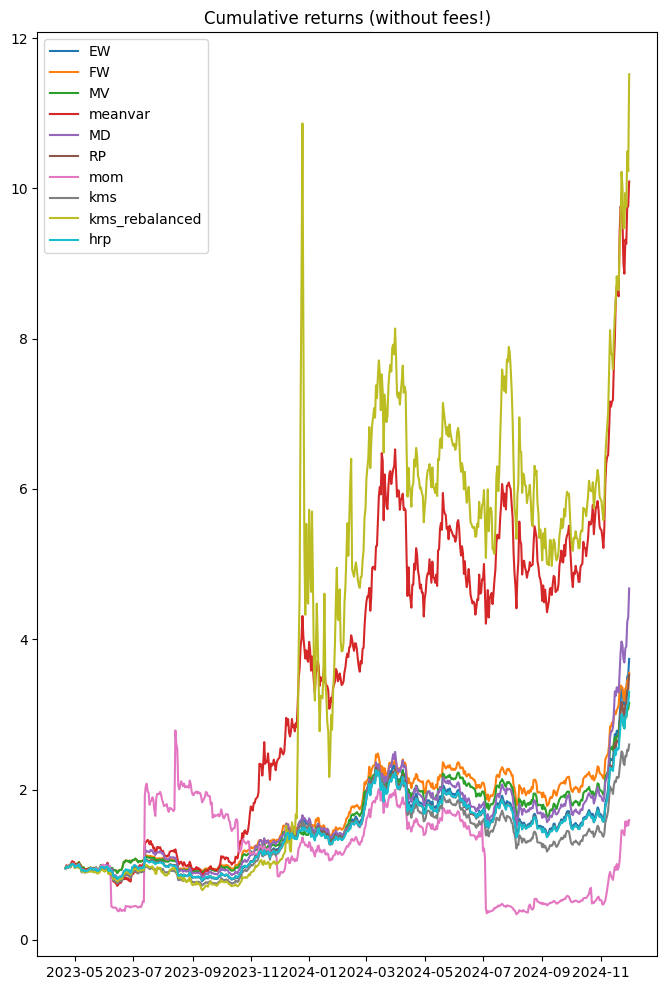

In [ ]:
pf_ret = pf_ret.dropna()


plt.figure(figsize=(8, 12))
plt.plot((1+pf_ret['EW']).cumprod(), label='EW')
plt.plot((1+pf_ret['FW']).cumprod(), label='FW')
plt.plot((1+pf_ret['MV']).cumprod(), label='MV')
plt.plot((1+pf_ret['meanvar']).cumprod(), label='meanvar')
plt.plot((1+pf_ret['MD']).cumprod(), label='MD')
plt.plot((1+pf_ret['RP']).cumprod(), label='RP')
plt.plot((1+pf_ret['mom']).cumprod(), label='mom')
plt.plot((1+pf_ret['kms']).cumprod(), label='kms')
plt.plot((1+pf_ret['kms_rebalanced']).cumprod(), label='kms_rebalanced')
plt.plot((1+pf_ret['hrp']).cumprod(), label='hrp')
plt.legend()
plt.title('Cumulative returns (without fees!)')
plt.show()

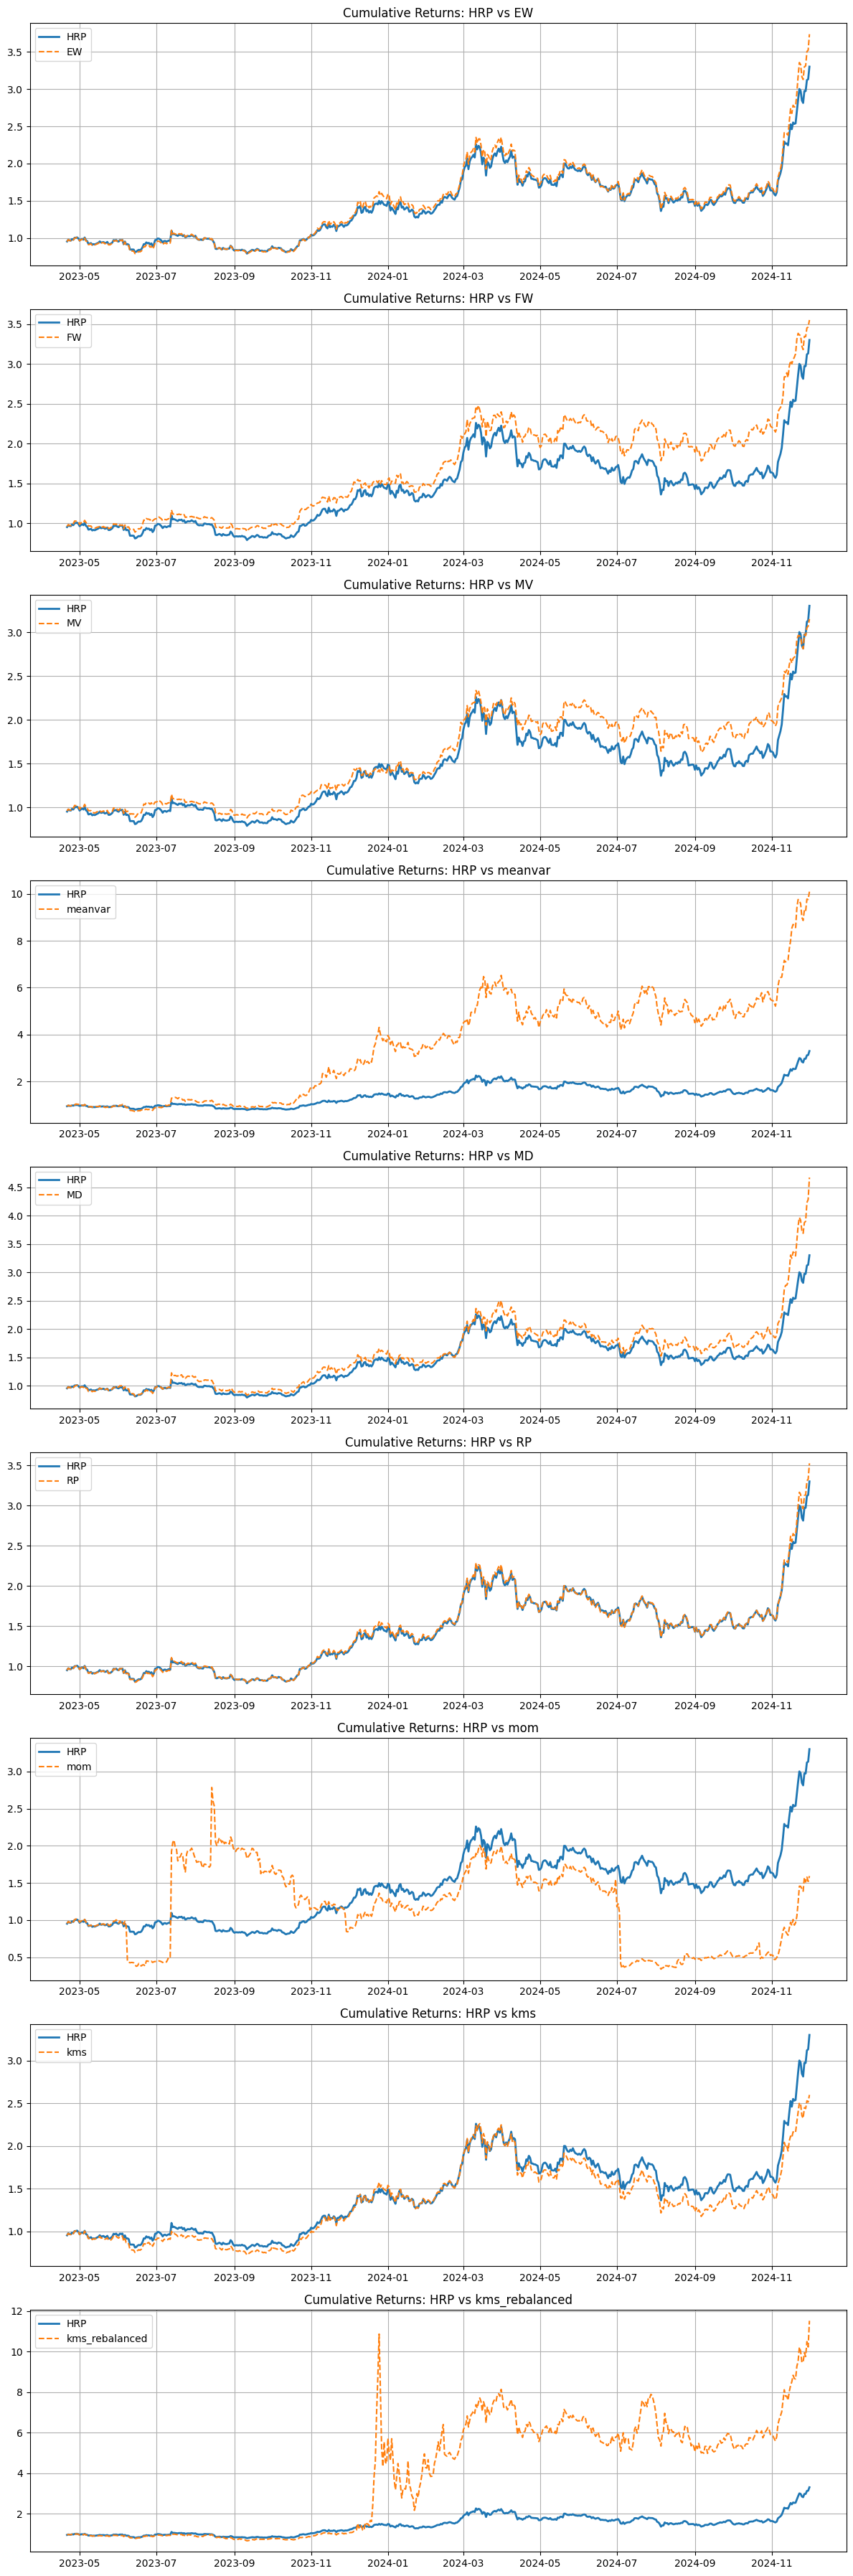

In [ ]:
import matplotlib.pyplot as plt

# Drop missing values
pf_ret = pf_ret.dropna()

# List of all strategies
strategies = ['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP', 'mom', 'kms', 'kms_rebalanced', 'hrp']

# Pair HRP with each strategy (excluding HRP vs. HRP)
hrp_combinations = [strategy for strategy in strategies if strategy != 'hrp']

# Plot HRP combinations
plt.figure(figsize=(12, len(hrp_combinations) * 4))  # Adjust figure size based on number of plots

for i, strategy in enumerate(hrp_combinations, 1):
    plt.subplot(len(hrp_combinations), 1, i)
    plt.plot((1 + pf_ret['hrp']).cumprod(), label='HRP', linestyle='-', linewidth=2)
    plt.plot((1 + pf_ret[strategy]).cumprod(), label=strategy, linestyle='--')
    plt.legend()
    plt.title(f'Cumulative Returns: HRP vs {strategy}')
    plt.grid()

plt.tight_layout()
plt.show()


# Kurtosis Minimization Strategy (KMS)

Reference: [Analyzing Portfolio Optimization in Cryptocurrency Markets: A Comparative Study of Short-Term Investment Strategies Using Hourly Data Approach](https://www.mdpi.com/1911-8074/17/3/125)

Note: We tuned the strategy and applied KMS on daily data instead of hourly to match with existing strategies.

In [ ]:
log_daily_returns = np.log(daily_data / daily_data.shift(1))
log_daily_returns = log_daily_returns[log_daily_returns.index >= '2022-12-22'][1:]
log_daily_returns.head()

,BTCUSD,ETHUSD,XRPUSD,ADAUSD,DOGEUSD,DOTUSD,LTCUSD,SOLUSD
date,,,,,,,,
2022-12-23,-0.002500,0.001887,0.013947,0.012141,-0.006222,-0.012436,-0.005609,0.003750
2022-12-24,0.003570,0.000164,-0.007048,-0.002548,0.011891,-0.005153,-0.000304,-0.033192
2022-12-25,-0.000653,-0.001968,-0.018492,0.001776,-0.019723,0.003811,0.050122,-0.000676
2022-12-26,0.005275,0.007850,0.057764,0.015847,-0.019852,0.023223,0.020897,-0.005238
2022-12-27,-0.012910,-0.013696,0.003299,-0.016195,-0.012509,-0.020319,-0.026844,-0.026032


In [ ]:
# Calculate kurtosis for each asset
kurtosis = log_daily_returns.kurtosis()

# Calculate weights inversely proportional to kurtosis
weights = 1 / kurtosis
weights /= weights.sum()  # Normalize to sum to 1

print("Kurtosis:")
kurtosis

Kurtosis:


,0
BTCUSD,2.419166
ETHUSD,3.858861
XRPUSD,47.638180
ADAUSD,4.581326
DOGEUSD,4.256658
DOTUSD,4.411806
LTCUSD,5.776183
SOLUSD,2.834171


In [ ]:
print("Portfolio Weights:")
weights

Portfolio Weights:


,0
BTCUSD,0.217638
ETHUSD,0.136440
XRPUSD,0.011052
ADAUSD,0.114923
DOGEUSD,0.123689
DOTUSD,0.119339
LTCUSD,0.091150
SOLUSD,0.185769


In [ ]:
# Compute weighted returns for each asset
individual_weighted_returns = log_daily_returns.mul(weights, axis=1)

# Check individual contributions
print("Individual Asset Weighted Returns:")
individual_weighted_returns.head()

# Total portfolio return as a sum of all assets' weighted returns
# portfolio_returns = individual_weighted_returns.sum(axis=1) #  (weights * daily_returns).sum(axis=1)

# print("Total Portfolio Returns:")
# print(portfolio_returns.head())

Individual Asset Weighted Returns:


,BTCUSD,ETHUSD,XRPUSD,ADAUSD,DOGEUSD,DOTUSD,LTCUSD,SOLUSD
date,,,,,,,,
2022-12-23,-0.000544,0.000257,0.000154,0.001395,-0.000770,-0.001484,-0.000511,0.000697
2022-12-24,0.000777,0.000022,-0.000078,-0.000293,0.001471,-0.000615,-0.000028,-0.006166
2022-12-25,-0.000142,-0.000269,-0.000204,0.000204,-0.002440,0.000455,0.004569,-0.000126
2022-12-26,0.001148,0.001071,0.000638,0.001821,-0.002456,0.002771,0.001905,-0.000973
2022-12-27,-0.002810,-0.001869,0.000036,-0.001861,-0.001547,-0.002425,-0.002447,-0.004836


In [ ]:
#daily_asset_returns_hr = individual_weighted_returns.groupby(pd.Grouper(freq='D')).mean() * 24

In [ ]:
# Adding KMS to pf_ret
pf_ret['kms'] = individual_weighted_returns.sum(axis = 1)

In [ ]:
# annualized return and volatility
freq = 'daily'
if freq == 'monthly':
    ann_mean = ((1+pf_ret.mean()) ** 12) - 1
    ann_vol = pf_ret.std() * (12**0.5)
elif freq == 'daily':
    ann_mean = ((1+pf_ret.mean()) ** 365) - 1
    ann_vol = pf_ret.std() * (365**0.5)

# Sharpe ratio
sharpe_ratio = ann_mean / ann_vol

# maximum drawdown
cummulative_return = (1 + pf_ret).cumprod()
previous_peaks = cummulative_return.cummax()
drawdown = (previous_peaks - cummulative_return)/previous_peaks
max_drawdown = abs(drawdown.max())

summ_tab = pd.DataFrame(columns=['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP','kms']) # mom
summ_tab.loc['Annualized return'] = ann_mean
summ_tab.loc['Annualized volatility'] = ann_vol
summ_tab.loc['Sharpe ratio'] = sharpe_ratio
summ_tab.loc['Max DD'] = max_drawdown

summ_tab

,EW,FW,MV,meanvar,MD,RP,kms
Annualized return,1.664370,1.452132,1.273342,4.607540,2.128255,1.545557,1.119046
Annualized volatility,0.578896,0.480513,0.476902,0.781442,0.619798,0.561237,0.568567
Sharpe ratio,2.875077,3.022046,2.670030,5.896203,3.433790,2.753840,1.968187
Max DD,0.411407,0.281095,0.301437,0.355389,0.391324,0.404256,0.480656


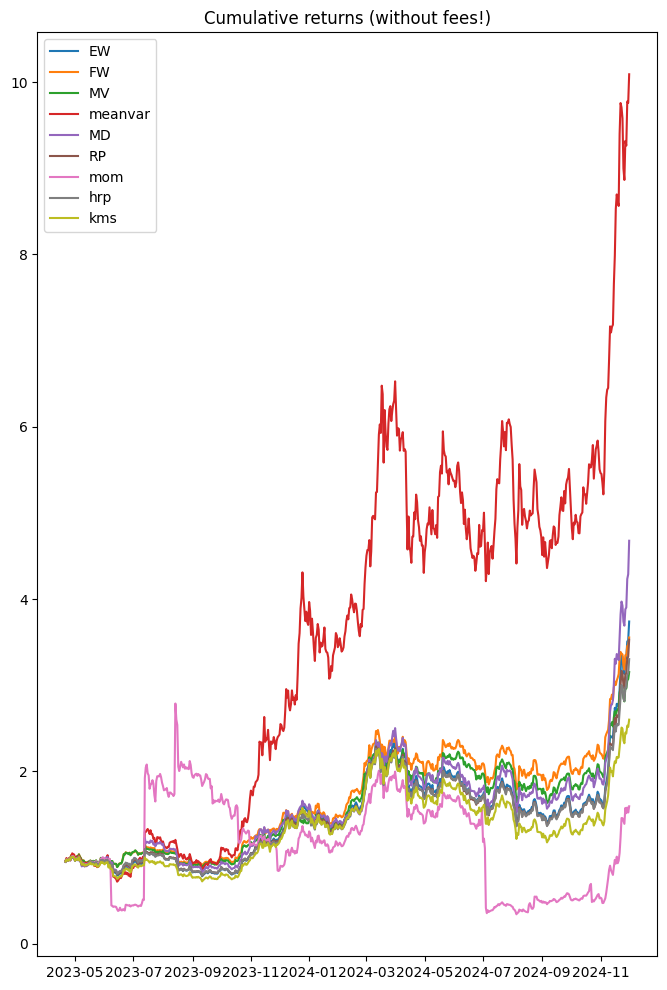

In [ ]:
pf_ret = pf_ret.dropna()


plt.figure(figsize=(8, 12))
plt.plot((1+pf_ret['EW']).cumprod(), label='EW')
plt.plot((1+pf_ret['FW']).cumprod(), label='FW')
plt.plot((1+pf_ret['MV']).cumprod(), label='MV')
plt.plot((1+pf_ret['meanvar']).cumprod(), label='meanvar')
plt.plot((1+pf_ret['MD']).cumprod(), label='MD')
plt.plot((1+pf_ret['RP']).cumprod(), label='RP')
plt.plot((1+pf_ret['mom']).cumprod(), label='mom')
plt.plot((1+pf_ret['hrp']).cumprod(), label='hrp')
plt.plot((1+pf_ret['kms']).cumprod(), label='kms')
plt.legend()
plt.title('Cumulative returns (without fees!)')
plt.show()

In [ ]:
# Define rebalancing period (e.g., weekly)
rebalancing_period = 70  # 5 trading days for weekly

# Initialize variables to store individual contributions
crypto_contributions = pd.DataFrame(index=daily_returns.index, columns=daily_returns.columns).fillna(0)

for i in range(0, len(daily_returns), rebalancing_period):
    # Subset data for the current period
    period_data = daily_returns.iloc[i:i + rebalancing_period]

    # Recalculate weights
    period_kurtosis = period_data.kurtosis()
    period_weights = 1 / period_kurtosis
    period_weights /= period_weights.sum() # period_weights = period_weights / sum(period_weights)

    # Calculate individual contributions for the period
    for asset in daily_returns.columns:
        crypto_contributions.loc[period_data.index, asset] = period_weights[asset] * period_data[asset]

# Check individual contributions
print("Individual Contributions Over Time:")
print(crypto_contributions.head())

Individual Contributions Over Time:
              BTCUSD    ETHUSD    XRPUSD    ADAUSD   DOGEUSD    DOTUSD  \
date                                                                     
2022-12-23  0.000058 -0.000160  0.006305 -0.003566  0.000437  0.000497   
2022-12-24 -0.000083 -0.000014 -0.003153  0.000743 -0.000844  0.000207   
2022-12-25  0.000015  0.000167 -0.008225 -0.000519  0.001377 -0.000153   
2022-12-26 -0.000123 -0.000669  0.026696 -0.004663  0.001386 -0.000944   
2022-12-27  0.000298  0.001155  0.001484  0.004690  0.000877  0.000808   

              LTCUSD    SOLUSD  
date                            
2022-12-23 -0.006014 -0.000050  
2022-12-24 -0.000327  0.000436  
2022-12-25  0.055263  0.000009  
2022-12-26  0.022704  0.000070  
2022-12-27 -0.028478  0.000343  


In [ ]:
# Adding KMS to pf_ret
pf_ret['kms_rebalanced'] = crypto_contributions.sum(axis = 1)

In [ ]:
# annualized return and volatility
freq = 'daily'
if freq == 'monthly':
    ann_mean = ((1+pf_ret.mean()) ** 12) - 1
    ann_vol = pf_ret.std() * (12**0.5)
elif freq == 'daily':
    ann_mean = ((1+pf_ret.mean()) ** 365) - 1
    ann_vol = pf_ret.std() * (365**0.5)

# Sharpe ratio
sharpe_ratio = ann_mean / ann_vol

# maximum drawdown
cummulative_return = (1 + pf_ret).cumprod()
previous_peaks = cummulative_return.cummax()
drawdown = (previous_peaks - cummulative_return)/previous_peaks
max_drawdown = abs(drawdown.max())

summ_tab = pd.DataFrame(columns=['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP','kms','kms_rebalanced'])
summ_tab.loc['Annualized return'] = ann_mean
summ_tab.loc['Annualized volatility'] = ann_vol
summ_tab.loc['Sharpe ratio'] = sharpe_ratio
summ_tab.loc['Max DD'] = max_drawdown

summ_tab

,EW,FW,MV,meanvar,MD,RP,kms,kms_rebalanced
Annualized return,1.664370,1.452132,1.273342,4.607540,2.128255,1.545557,1.119046,10.559359
Annualized volatility,0.578896,0.480513,0.476902,0.781442,0.619798,0.561237,0.568567,1.421160
Sharpe ratio,2.875077,3.022046,2.670030,5.896203,3.433790,2.753840,1.968187,7.430100
Max DD,0.411407,0.281095,0.301437,0.355389,0.391324,0.404256,0.480656,0.800570


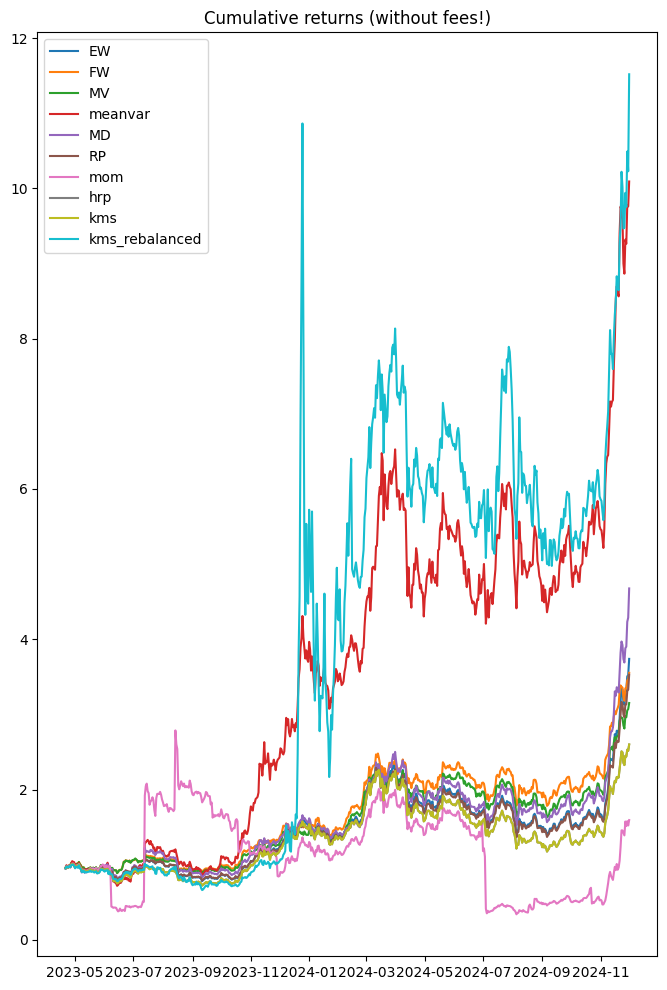

In [ ]:
pf_ret = pf_ret.dropna()


plt.figure(figsize=(8, 12))
plt.plot((1+pf_ret['EW']).cumprod(), label='EW')
plt.plot((1+pf_ret['FW']).cumprod(), label='FW')
plt.plot((1+pf_ret['MV']).cumprod(), label='MV')
plt.plot((1+pf_ret['meanvar']).cumprod(), label='meanvar')
plt.plot((1+pf_ret['MD']).cumprod(), label='MD')
plt.plot((1+pf_ret['RP']).cumprod(), label='RP')
plt.plot((1+pf_ret['mom']).cumprod(), label='mom')
plt.plot((1+pf_ret['kms']).cumprod(), label='hrp')
plt.plot((1+pf_ret['kms']).cumprod(), label='kms')
plt.plot((1+pf_ret['kms_rebalanced']).cumprod(), label='kms_rebalanced')
plt.legend()
plt.title('Cumulative returns (without fees!)')
plt.show()

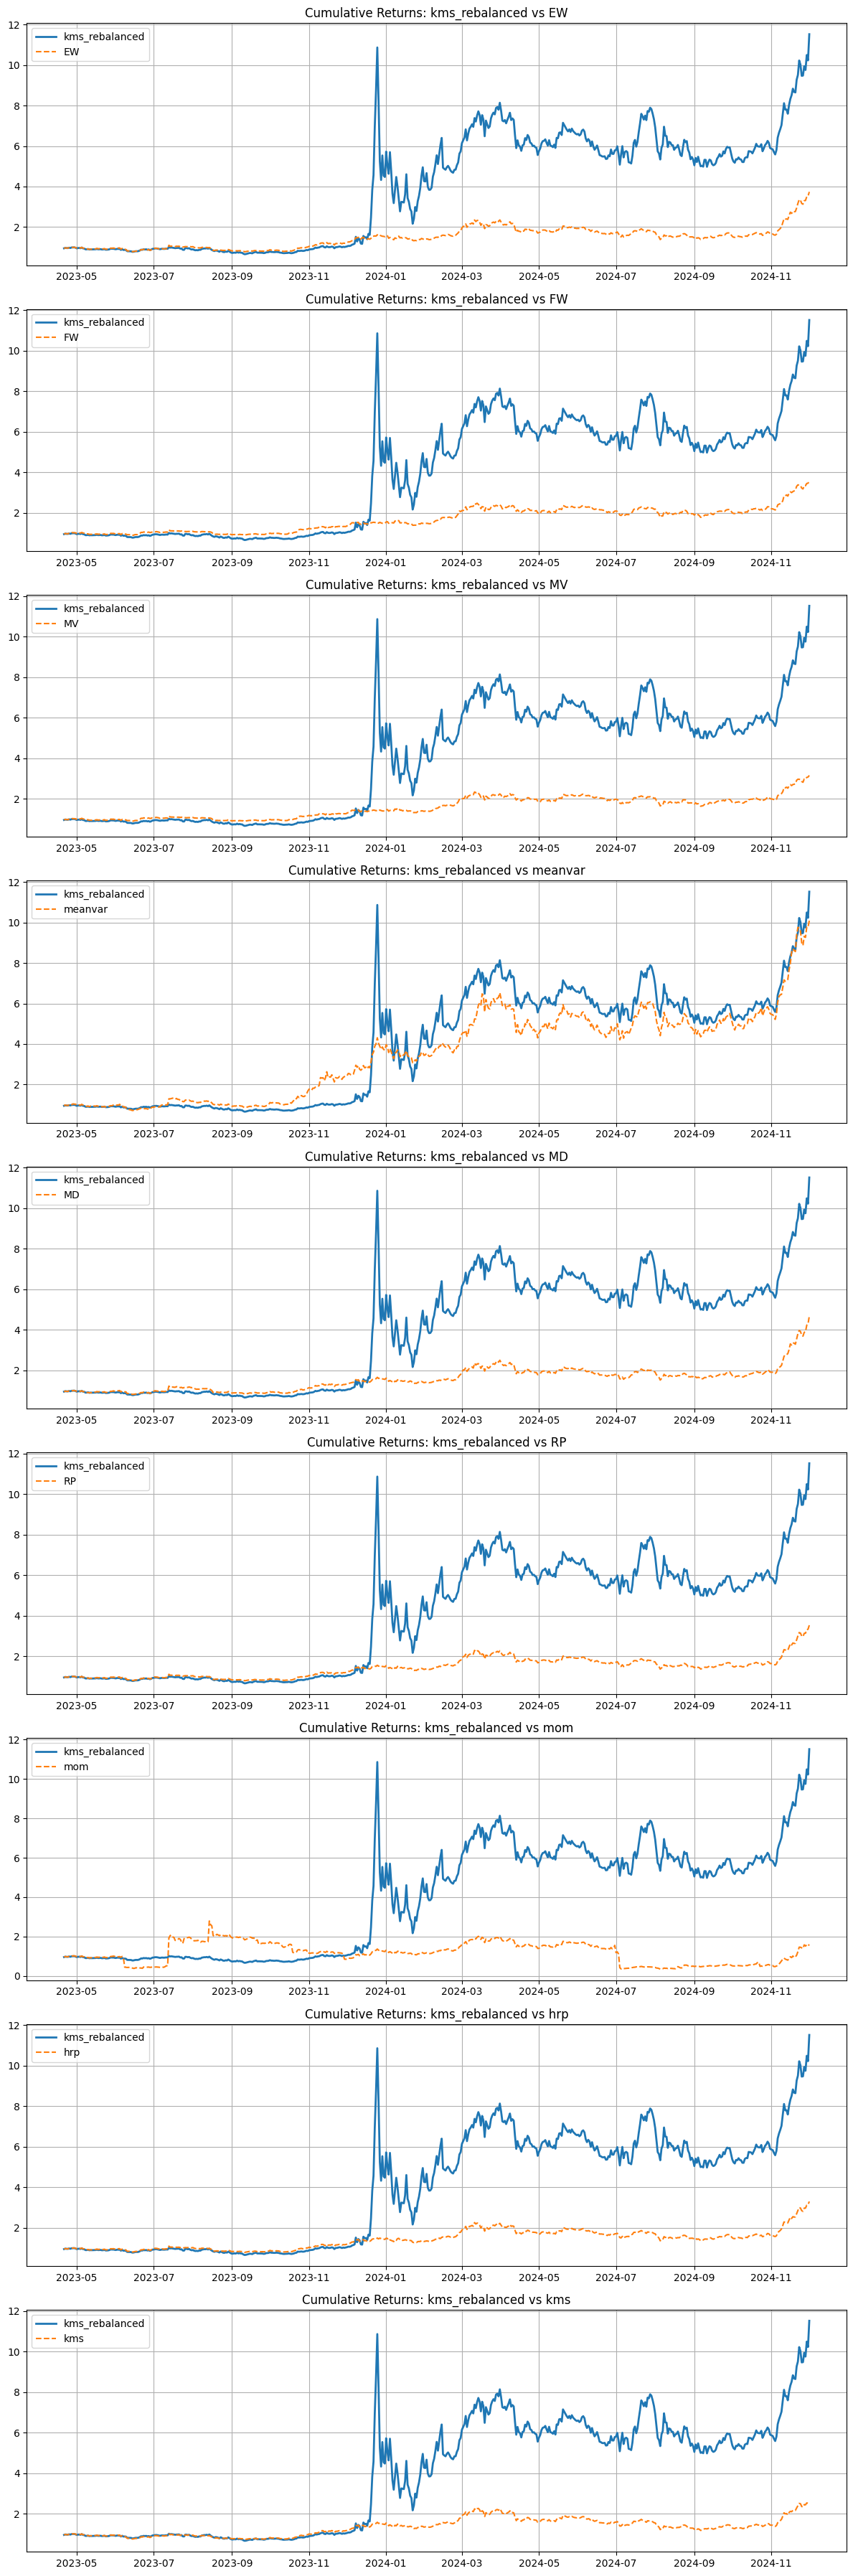

In [ ]:
import matplotlib.pyplot as plt

# Drop missing values
pf_ret = pf_ret.dropna()

# List of all strategies
strategies = ['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP', 'mom', 'hrp','kms', 'kms_rebalanced']

# Pair HRP with each strategy (excluding HRP vs. HRP)
kms_rebalanced_combinations = [strategy for strategy in strategies if strategy != 'kms_rebalanced']

# Plot HRP combinations
plt.figure(figsize=(12, len(kms_rebalanced_combinations) * 4))  # Adjust figure size based on number of plots

for i, strategy in enumerate(kms_rebalanced_combinations, 1):
    plt.subplot(len(kms_rebalanced_combinations), 1, i)
    plt.plot((1 + pf_ret['kms_rebalanced']).cumprod(), label='kms_rebalanced', linestyle='-', linewidth=2)
    plt.plot((1 + pf_ret[strategy]).cumprod(), label=strategy, linestyle='--')
    plt.legend()
    plt.title(f'Cumulative Returns: kms_rebalanced vs {strategy}')
    plt.grid()

plt.tight_layout()
plt.show()


# HRP Scratch

In [ ]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as spdist

def preprocess_returns(returns, verbose=False):
    """
    Comprehensive returns preprocessing pipeline

    Args:
        returns (pd.DataFrame): Raw returns data
        verbose (bool): Print detailed preprocessing information

    Returns:
        pd.DataFrame: Cleaned and preprocessed returns
    """
    # Create a copy to avoid modifying original data
    processed_returns = returns.copy()

    # 1. Check for and handle missing values
    initial_nan_count = processed_returns.isna().sum()

    # Forward fill missing values (assumes time series data)
    processed_returns.fillna(method='ffill', inplace=True)

    # Backward fill any remaining missing values at the start
    processed_returns.fillna(method='bfill', inplace=True)

    # If still any NaNs, drop
    processed_returns.dropna(inplace=True)

    # 2. Winsorization to handle extreme values
    def winsorize(series, lower_quantile=0.01, upper_quantile=0.99):
        """
        Winsorize a series by capping at specified quantiles

        Args:
            series (pd.Series): Input series
            lower_quantile (float): Lower quantile threshold
            upper_quantile (float): Upper quantile threshold

        Returns:
            pd.Series: Winsorized series
        """
        lower_bound = series.quantile(lower_quantile)
        upper_bound = series.quantile(upper_quantile)
        return np.clip(series, lower_bound, upper_bound)

    # Apply winsorization to each column
    for col in processed_returns.columns:
        processed_returns[col] = winsorize(processed_returns[col])

    # 3. Remove any remaining NaN values after preprocessing
    processed_returns.dropna(inplace=True)

    # Verbose logging
    if verbose:
        print("Preprocessing Report:")
        print("-" * 20)
        print("Initial NaN counts:")
        print(initial_nan_count)
        print("\nFinal DataFrame shape:", processed_returns.shape)
        print("\nDescriptive Statistics:")
        print(processed_returns.describe())

    return processed_returns

In [ ]:
preprocess_rets = preprocess_returns(daily_returns, verbose=False)

In [ ]:
def hierarchical_risk_parity(returns, randomize_seed=42):
    """
    Implement Hierarchical Risk Parity portfolio allocation

    Args:
        returns (pd.DataFrame): Preprocessed asset returns
        randomize_seed (int): Random seed for reproducibility

    Returns:
        np.ndarray: HRP portfolio weights
    """
    # Set random seed for reproducibility
    np.random.seed(randomize_seed)

    # Compute correlation matrix
    corr_matrix = returns.corr()

    # Convert correlation matrix to distance matrix
    dist_matrix = np.sqrt(2 * (1 - corr_matrix))

    # Perform hierarchical clustering
    linkage_matrix = sch.linkage(spdist.squareform(dist_matrix), method='ward')

    # Get the order of the clustering
    leaves_order = sch.leaves_list(linkage_matrix)

    # Reorder the correlation matrix and returns based on clustering
    reordered_corr = corr_matrix.iloc[leaves_order, leaves_order]
    reordered_returns = returns.iloc[:, leaves_order]

    def recursive_portfolio_weights(cov_matrix):
        """
        Recursively compute portfolio weights

        Args:
            cov_matrix (np.ndarray): Covariance matrix

        Returns:
            np.ndarray: Portfolio weights
        """
        # Base case
        if cov_matrix.shape[0] <= 2:
            return np.array([0.5, 0.5]) if cov_matrix.shape[0] == 2 else np.array([1.0])

        # Split the matrix
        mid = cov_matrix.shape[0] // 2
        left_cov = cov_matrix[:mid, :mid]
        right_cov = cov_matrix[mid:, mid:]

        # Recursive weights
        left_weights = recursive_portfolio_weights(left_cov)
        right_weights = recursive_portfolio_weights(right_cov)

        # Compute cluster variances
        def compute_cluster_variance(weights, cov_matrix):
            return np.dot(weights.T, np.dot(cov_matrix, weights))

        # Balance the two clusters
        left_var = compute_cluster_variance(left_weights, left_cov)
        right_var = compute_cluster_variance(right_weights, right_cov)

        # Adjust weights to equalize cluster risks
        total_var = left_var + right_var

        # Combine weights
        combined_weights = np.zeros(cov_matrix.shape[0])
        combined_weights[:mid] = left_weights * np.sqrt(total_var / (2 * left_var))
        combined_weights[mid:] = right_weights * np.sqrt(total_var / (2 * right_var))

        return combined_weights

    # Compute HRP weights based on covariance matrix
    hrp_weights = recursive_portfolio_weights(reordered_corr.values)

    # Reverse the weights to match original asset order
    reverse_order = np.argsort(leaves_order)
    final_weights = hrp_weights[reverse_order]

    # Normalize weights to sum to 1
    final_weights = final_weights / np.sum(final_weights)

    return final_weights

In [ ]:
wgts = hierarchical_risk_parity(preprocess_rets, randomize_seed=42)

In [ ]:
pf_ret['hrp'] = preprocess_rets.dot(wgts)

In [ ]:
# annualized return and volatility
freq = 'daily'
if freq == 'monthly':
    ann_mean = ((1+pf_ret.mean()) ** 12) - 1
    ann_vol = pf_ret.std() * (12**0.5)
elif freq == 'daily':
    ann_mean = ((1+pf_ret.mean()) ** 365) - 1
    ann_vol = pf_ret.std() * (365**0.5)

# Sharpe ratio
sharpe_ratio = ann_mean / ann_vol

# maximum drawdown
cummulative_return = (1 + portfolio_return).cumprod()
previous_peaks = cummulative_return.cummax()
drawdown = (previous_peaks - cummulative_return)/previous_peaks
max_drawdown = abs(drawdown.max())

summ_tab_martina = pd.DataFrame(columns=['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP', 'mom','kms','hrp'])
summ_tab_martina.loc['Annualized return'] = ann_mean
summ_tab_martina.loc['Annualized volatility'] = ann_vol
summ_tab_martina.loc['Sharpe ratio'] = sharpe_ratio
summ_tab_martina.loc['Max DD'] = max_drawdown

summ_tab_martina

,EW,FW,MV,meanvar,MD,RP,mom,kms,hrp
Annualized return,1.879068,1.783636,1.600459,5.156495,2.244936,1.773601,NaN,NaN,1.469617
Annualized volatility,0.580545,0.484829,0.481050,0.818669,0.618385,0.563009,NaN,NaN,0.539710
Sharpe ratio,3.236733,3.678899,3.327010,6.298629,3.630322,3.150218,NaN,NaN,2.722974
Max DD,0.999771,0.999771,0.999771,0.999771,0.999771,0.999771,0.999771,0.999771,0.999771


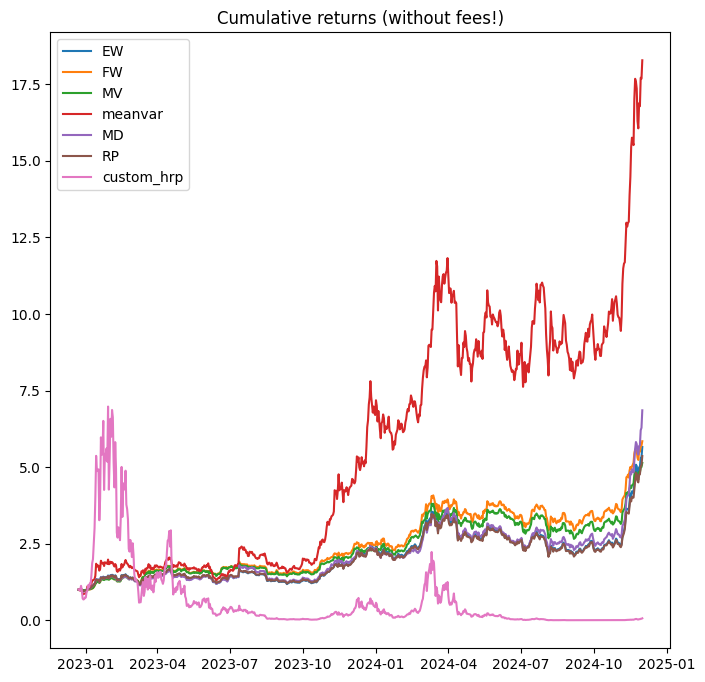

In [ ]:
pf_ret = pf_ret.dropna()


plt.figure(figsize=(8, 8))
plt.plot((1+pf_ret['EW']).cumprod(), label='EW')
plt.plot((1+pf_ret['FW']).cumprod(), label='FW')
plt.plot((1+pf_ret['MV']).cumprod(), label='MV')
plt.plot((1+pf_ret['meanvar']).cumprod(), label='meanvar')
plt.plot((1+pf_ret['MD']).cumprod(), label='MD')
plt.plot((1+pf_ret['RP']).cumprod(), label='RP')
plt.plot((1+pf_ret['custom_hrp']).cumprod(), label='custom_hrp')
#plt.plot((1+pf_ret['mom']).cumprod(), label='mom')
plt.legend()
plt.title('Cumulative returns (without fees!)')
plt.show()

In [ ]:
hrp = calculate_portfolio_metrics(preprocessed_rets, wgts)
hrp

{'Return': 6.042907276654585,
 'Volatility': 3.803514179098832,
 'Sharpe Ratio': 1.588769488454052}